# **SETUP**

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import re
import os

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

import shap
from statsmodels.graphics.tsaplots import plot_acf

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    mean_absolute_percentage_error,
    make_scorer,
    mean_squared_error,
    root_mean_squared_error,
    mean_absolute_error,
    r2_score
)
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.feature_selection import mutual_info_regression

from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor, XGBClassifier
from lightgbm import LGBMRegressor

import optuna
from optuna.samplers import TPESampler
from optuna.pruners import MedianPruner
from sklearn.ensemble import StackingRegressor


In [ ]:
df = pd.read_excel("HCMWeatherDaily.xlsx")

# **OVERALL**

This notebook combines the analyses from five tasks on the weather dataset for Ho Chi Minh City (Saigon). The dataset contains 3934 daily observations from 2015-01-01 to 2025-10-08, with 33 columns covering various meteorological variables. The data is sourced from weather stations (e.g., VVTS) and includes parameters like temperature, humidity, precipitation, wind, solar radiation, and more.

The target variable for forecasting is 'temp' (average daily temperature in °C).

Key dataset characteristics:
- No missing values in most columns (some like 'severerisk' have NaNs).
- Time-series nature with daily granularity.
- Tropical climate context: Stable temperatures (avg. ~28°C), high humidity, frequent rain.

The notebook is structured by tasks, followed by recommendations for data preprocessing and feature engineering.

#  **INTRODUCE THE DATA AND EXPLAIN**
**We will examine the variable types and explain the meaning of each variable in this section.**

In [ ]:
df.head()

,name,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,...,solarenergy,uvindex,severerisk,sunrise,sunset,moonphase,conditions,description,icon,stations
0,"10.82, 106.67",2015-01-01,31.0,23.0,26.6,31.3,23.0,26.9,17.9,60.4,...,19.9,8,NaN,2015-01-01T06:11:34,2015-01-01T17:41:42,0.36,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"48894099999,48900099999,VVTS"
1,"10.82, 106.67",2015-01-02,30.0,20.0,25.0,30.3,20.0,25.1,15.7,56.7,...,16.1,7,NaN,2015-01-02T06:11:58,2015-01-02T17:42:15,0.39,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"48894099999,48900099999,VVTS"
2,"10.82, 106.67",2015-01-03,32.0,23.0,26.7,33.4,23.0,27.4,18.9,63.3,...,16.0,8,NaN,2015-01-03T06:12:21,2015-01-03T17:42:47,0.43,"Rain, Partially cloudy",Partly cloudy throughout the day with rain in ...,rain,"48894099999,48900099999,VVTS"
3,"10.82, 106.67",2015-01-04,32.0,24.0,27.1,34.8,24.0,28.3,21.2,71.3,...,10.9,4,NaN,2015-01-04T06:12:44,2015-01-04T17:43:20,0.46,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"48894099999,48900099999,VVTS"
4,"10.82, 106.67",2015-01-05,30.9,25.0,26.7,33.6,25.0,27.8,22.0,76.3,...,14.1,8,NaN,2015-01-05T06:13:05,2015-01-05T17:43:53,0.50,"Rain, Partially cloudy",Partly cloudy throughout the day with morning ...,rain,"48894099999,48900099999,VVTS"


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3934 entries, 0 to 3933
Data columns (total 33 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              3934 non-null   object 
 1   datetime          3934 non-null   object 
 2   tempmax           3934 non-null   float64
 3   tempmin           3934 non-null   float64
 4   temp              3934 non-null   float64
 5   feelslikemax      3934 non-null   float64
 6   feelslikemin      3934 non-null   float64
 7   feelslike         3934 non-null   float64
 8   dew               3934 non-null   float64
 9   humidity          3934 non-null   float64
 10  precip            3934 non-null   float64
 11  precipprob        3934 non-null   int64  
 12  precipcover       3934 non-null   float64
 13  preciptype        3013 non-null   object 
 14  snow              3934 non-null   int64  
 15  snowdepth         3934 non-null   int64  
 16  windgust          3934 non-null   float64


| **Data Type** | **Total** | **Name** |
|-----------|----------|---------|
| float64 | 20 | tempmax, tempmin, temp, feelslikemax, feelslikemin, feelslike, dew, humidity, precip, precipcover, windgust, windspeed, winddir, sealevelpressure, cloudcover, visibility, solarradiation, solarenergy, severerisk, moonphase |
| int64 | 4 | precipprob, snow, snowdepth, uvindex |
| object | 9 | name, datetime, preciptype, sunrise, sunset, conditions, description, icon, stations |


**DATA TYPES CHECK**

**1. datetime:**  
Currently `object`, but this is actually a date/time column, so it should be converted to `datetime64[ns]`.



In [ ]:
#  datetime
df['datetime'] = pd.to_datetime(df['datetime'])
df['sunrise'] = pd.to_datetime(df['sunrise'])
df['sunset'] = pd.to_datetime(df['sunset'])
df = df.sort_values('datetime').reset_index(drop=True)

#  category
categorical_cols = ['preciptype', 'icon', 'stations', 'name']
for col in categorical_cols:
    df[col] = df[col].astype('category')

**VARIABLES CLASSSIFICATION**

Below is the classification of all **33 columns** in the weather dataset into **Numerical**, **Categorical**, and **Datetime** variables, along with their meanings and data types.

---

**Numerical Variables (23)**

| **Variable** | **Meaning** | **Data Type** | **Notes** |
|---------------|--------------|----------------|------------|
| `tempmax` | Maximum temperature during the day (°C) | float | Typically ranges 30–35°C |
| `tempmin` | Minimum temperature during the day (°C) | float | Typically ranges 22–26°C |
| `temp` | Average daily temperature (°C) | float | **Target variable** for prediction |
| `feelslikemax` | Maximum “feels like” temperature (°C) | float | Usually higher than `tempmax` |
| `feelslikemin` | Minimum “feels like” temperature (°C) | float | Close to or slightly higher than `tempmin` |
| `feelslike` | Average “feels like” temperature (°C) | float | Adjusted for humidity and wind |
| `dew` | Dew point temperature (°C) | float | Indicates humidity level in the air |
| `humidity` | Relative humidity (%) | float | Range: 60–100% typical in HCMC |
| `precip` | Amount of precipitation (mm) | float | Quantitative measure of rainfall |
| `precipcover` | Percentage of time with rain during the day (%) | int | Indicates duration of rain |
| `snow` | Amount of snowfall (mm) | int | Always ≈ 0 in Ho Chi Minh City |
| `snowdepth` | Accumulated snow depth (mm) | int | ≈ 0 in Ho Chi Minh City |
| `windgust` | Maximum wind speed (km/h) | float | Indicates extreme wind events |
| `windspeed` | Average daily wind speed (km/h) | float | Commonly 5–20 km/h |
| `winddir` | Wind direction (°) | float | 0–360°, cyclical feature |
| `sealevelpressure` | Atmospheric pressure (millibar) | float | Around 1000–1015 mb typical |
| `cloudcover` | Percentage of sky covered by clouds (%) | float | 0–100 |
| `visibility` | Visibility distance (km) | float | Indicates air clarity |
| `solarradiation` | Solar radiation intensity (W/m²) | float | Higher = sunnier day |
| `solarenergy` | Total solar energy (MJ/m²) | float | Measures accumulated sunlight |
| `uvindex` | Ultraviolet radiation index | int | Ranges from 0 (Low) to 11+ (Extreme) |
| `severerisk` | Severe weather risk index | int | May contain NaN |
| `moonphase` | Lunar phase fraction (0–1) | float | 0=new moon, 0.5=full moon |

---

**Categorical Variables (7)**

| **Variable** | **Meaning** | **Data Type** | **Notes** |
|---------------|--------------|----------------|------------|
| `name` | Location of weather data | object | “HoChiMinh” or “Hồ Chí Minh, Việt Nam” |
| `preciptype` | Type of precipitation | object | `"rain"`, `"snow"`, `"Missing"` |
| `conditions` | General weather condition | object | `"Clear"`, `"Rain"`, `"Partly Cloudy"` |
| `description` | Detailed text description of weather | object | e.g., `"Partly cloudy throughout the day with rain"` |
| `icon` | Visual weather icon label | object | `"clear-day"`, `"rain"`, `"partly-cloudy-day"` |
| `stations` | Weather station identifiers | object | Comma-separated codes |
| `source` | Source of data | object | `"obs"` (observed) or `"comb"` (combined data) |

---

**Datetime Variables (3)**

| **Variable** | **Meaning** | **Data Type** | **Notes** |
|---------------|--------------|----------------|------------|
| `datetime` | Date of weather record | datetime | Daily frequency, “YYYY-MM-DD” format |
| `sunrise` | Time of sunrise | datetime | ISO format, e.g., `2015-09-28T05:42:02` |
| `sunset` | Time of sunset | datetime | ISO format, e.g., `2015-09-28T17:45:56` |

---

**Summary**
| Variable Type | Count |
|----------------|--------|
| **Numerical Variables** | 23 |
| **Categorical Variables** | 7 |
| **Datetime Variables** | 3 |
| **Total Columns** | **33**  |



#   **DATA ANALYSIS**

 **CORRELATION HEATMAP**

In [ ]:
class correlation_matrix:
    '''
    Class to plot heatmap of Correlation Matrix and print Top Correlated Features with Target.
    Contains three methods:
        1. init method
        2. plot_correlation_matrix method
        3. target_top_corr method
    '''

    def __init__(self, data, figsize=(25,23), mask_upper=True,
                 tight_layout=True, linewidth=0.1, fontsize=10, cmap='Blues'):
        self.data = data
        self.figsize = figsize
        self.mask_upper = mask_upper
        self.tight_layout = tight_layout
        self.linewidth = linewidth
        self.fontsize = fontsize
        self.cmap = cmap

    def plot_correlation_matrix(self):
        print('-' * 100)
        self.corr_data = self.data.drop(['temp'], axis=1).corr(method='pearson')

        if self.mask_upper:
            mask_array = np.triu(np.ones(self.corr_data.shape))
        else:
            mask_array = np.zeros(self.corr_data.shape)


        plt.figure(figsize=self.figsize, tight_layout=self.tight_layout)
        sns.heatmap(self.corr_data, annot=False, mask=mask_array, linewidths=self.linewidth, cmap=self.cmap)
        plt.xticks(rotation=90, fontsize=self.fontsize)
        plt.yticks(fontsize=self.fontsize)
        plt.title("Correlation Heatmap for Numerical Features (Pearson)")
        plt.show()
        print('-' * 100)

    def target_top_corr(self, target_top_columns=10):
        corr_with_target = self.data.corr(method='pearson')['temp'].sort_values(ascending=False)
        top_corr_target_df = pd.DataFrame({
            'Column Name': corr_with_target.index,
            'Pearson-Correlation': corr_with_target.values
        }).head(target_top_columns)

        return top_corr_target_df



----------------------------------------------------------------------------------------------------


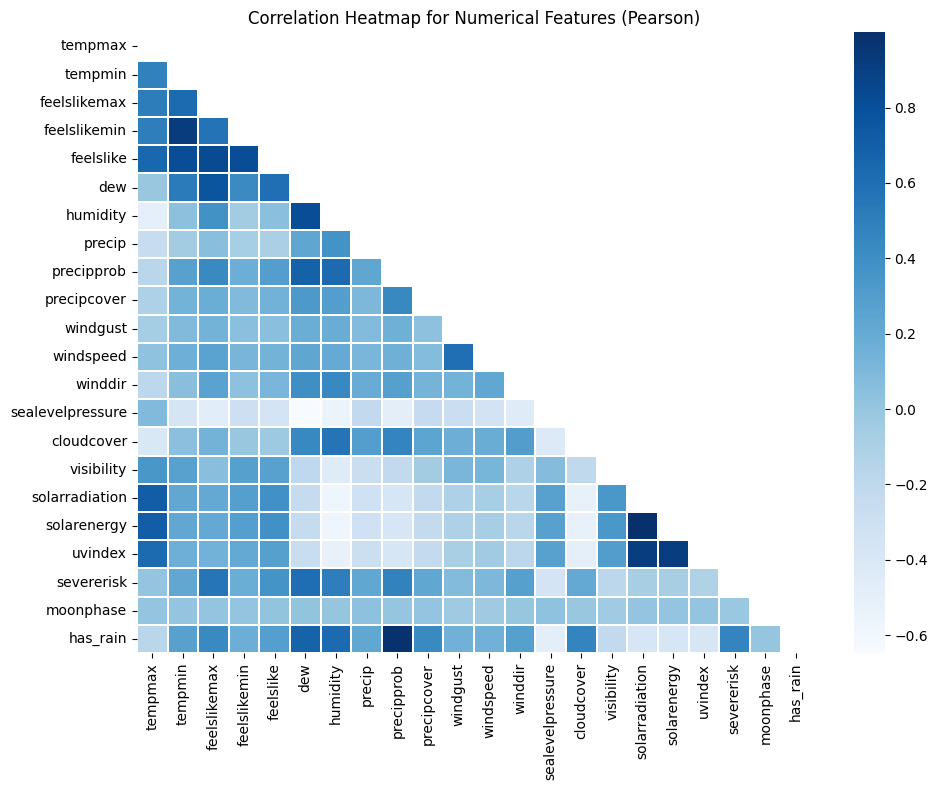

----------------------------------------------------------------------------------------------------


In [ ]:
# Dropping non-numeric columns and excluding specific columns
exclude_columns = ['snow', 'snowdepth']
df_numeric_col = df.select_dtypes(include=[np.number]).drop(columns=exclude_columns, errors='ignore')

corr_mat = correlation_matrix(df_numeric_col, figsize=(10,8))
corr_mat.plot_correlation_matrix()

 **HCM TEMPERATURE TREND**

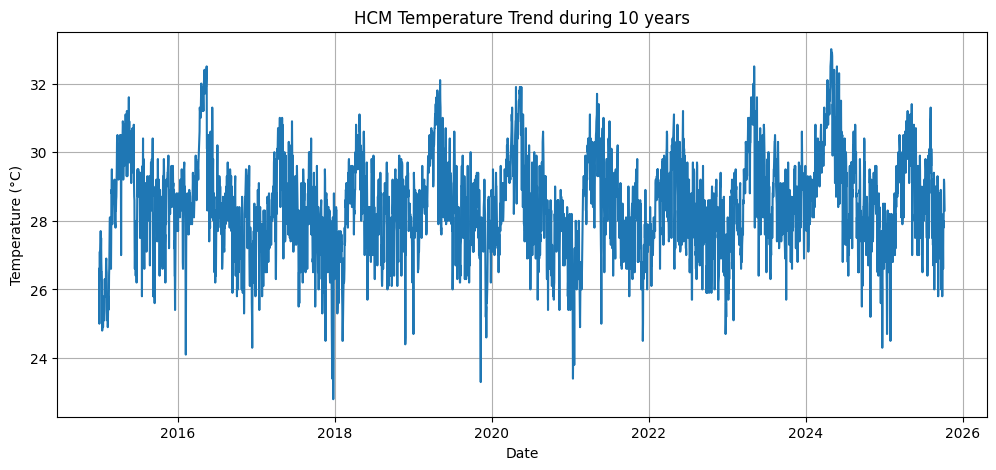

In [15]:
df['datetime'] = pd.to_datetime(df['datetime'])

# Plot temperature trend over the entire dataset
plt.figure(figsize=(12,5))
plt.plot(df['datetime'], df['temp'], color='tab:blue')
plt.title("HCM Temperature Trend during 10 years")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.grid(True)
plt.show()


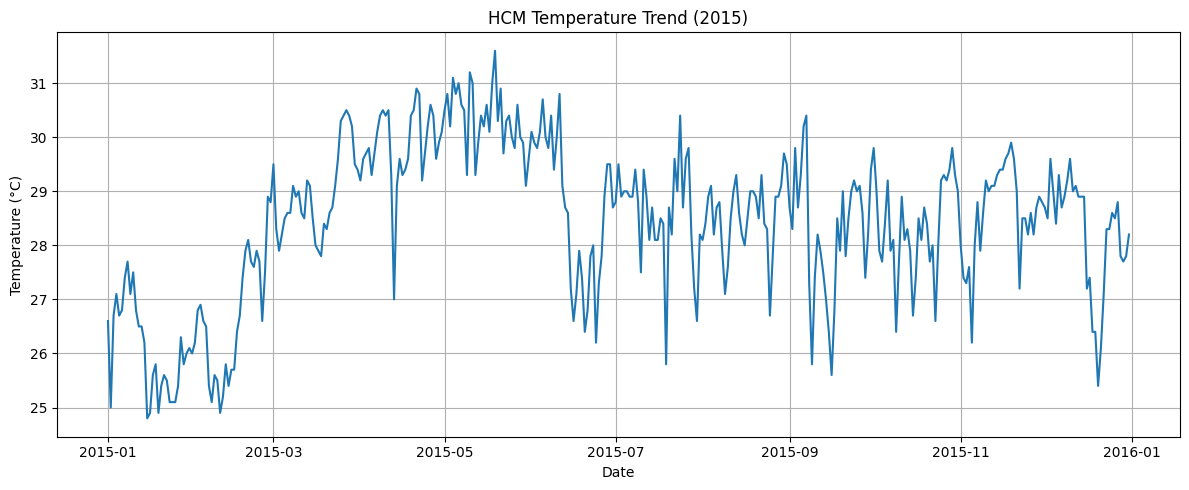

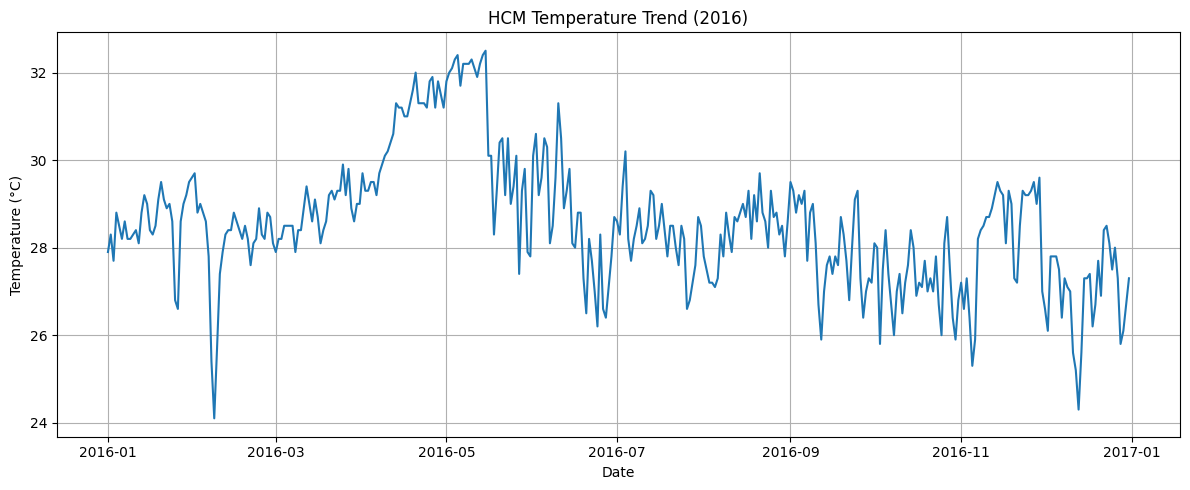

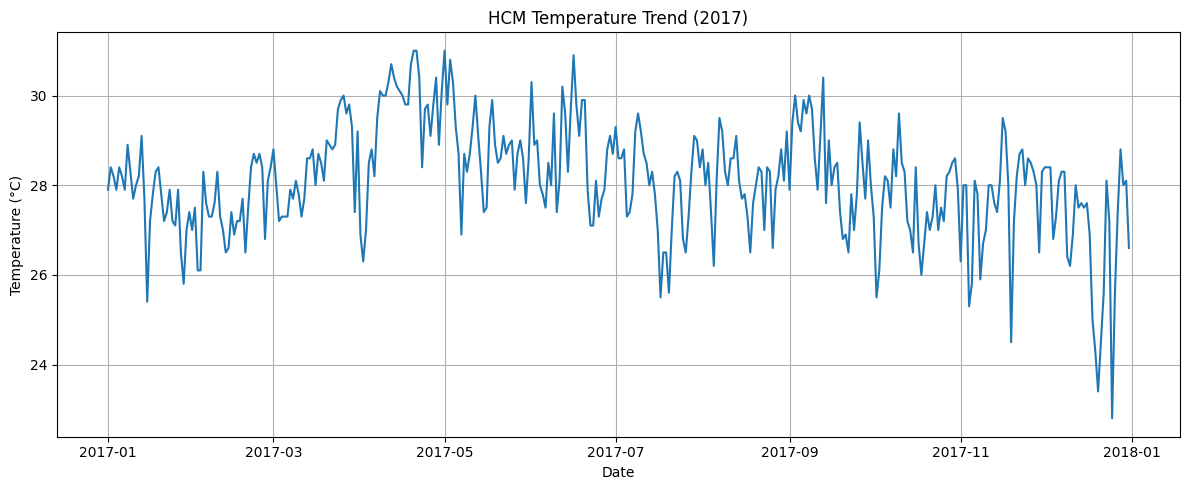

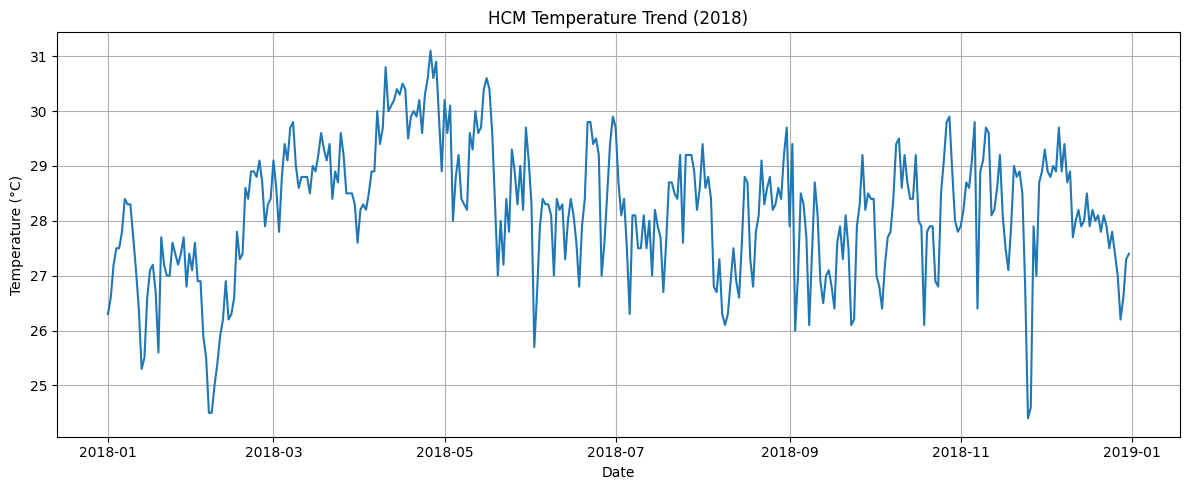

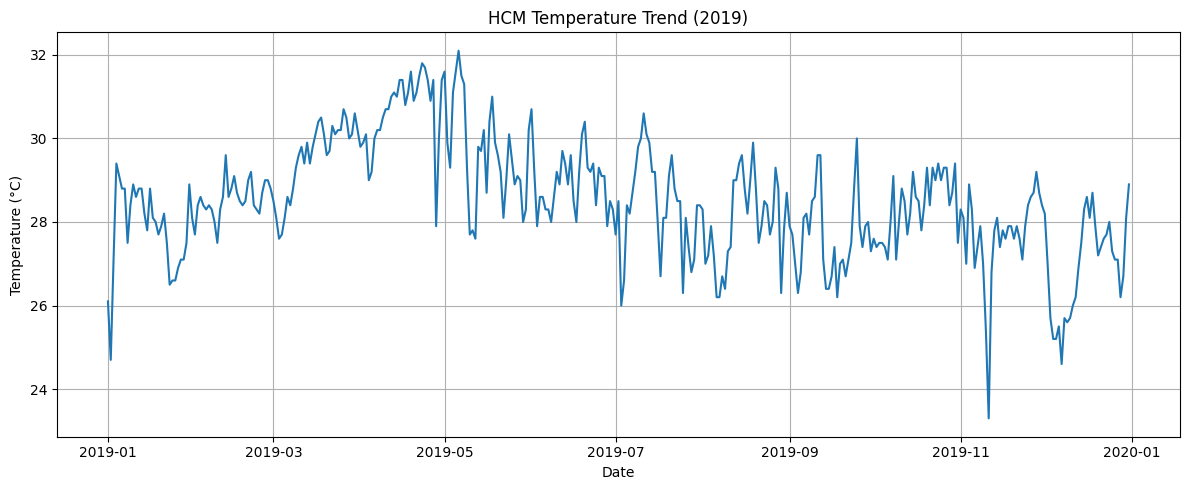

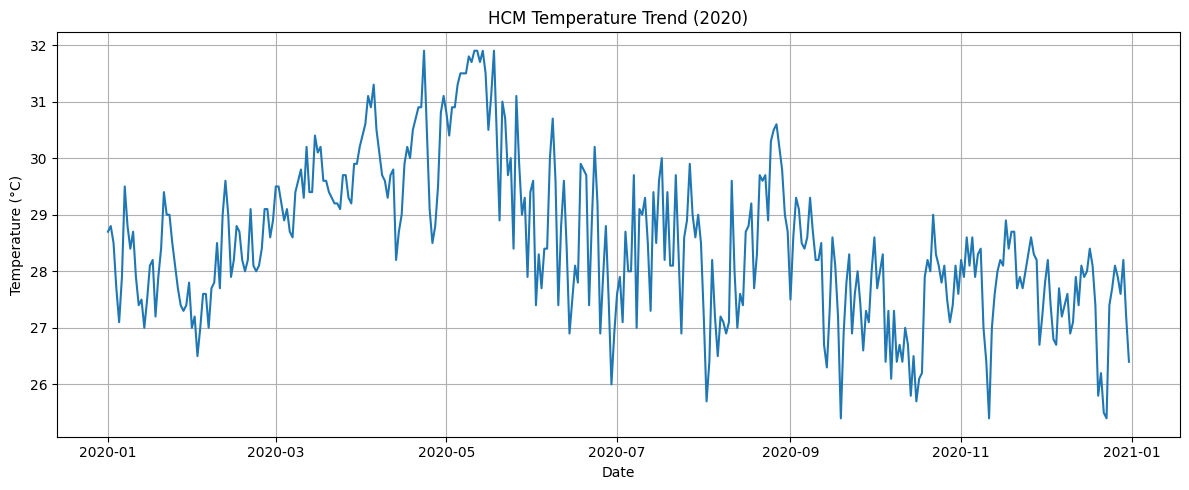

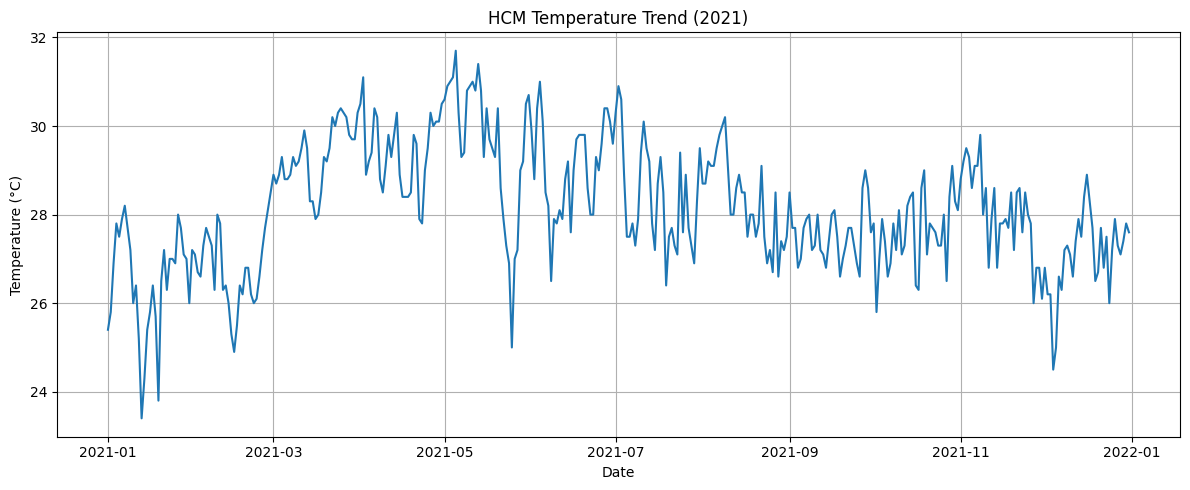

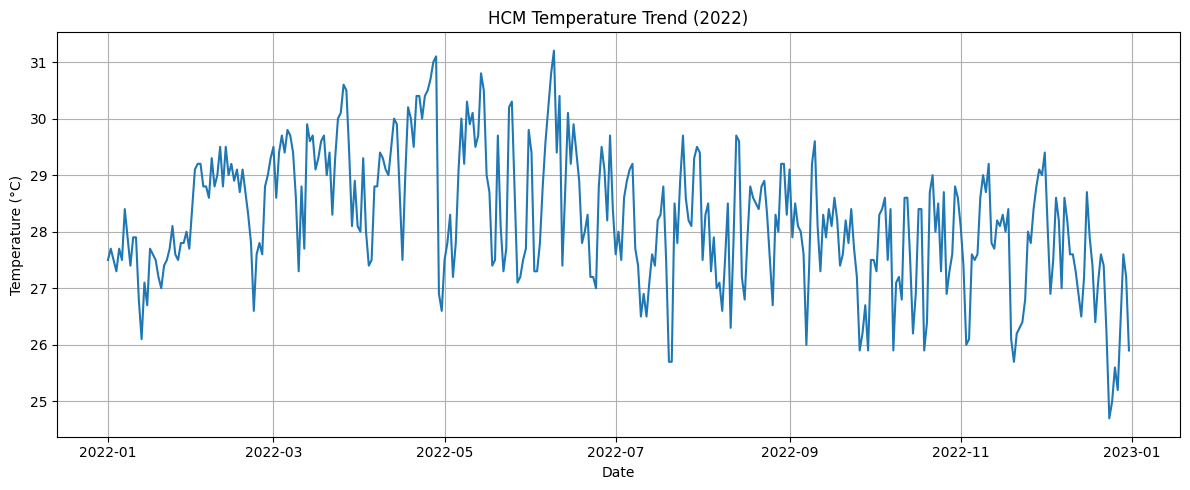

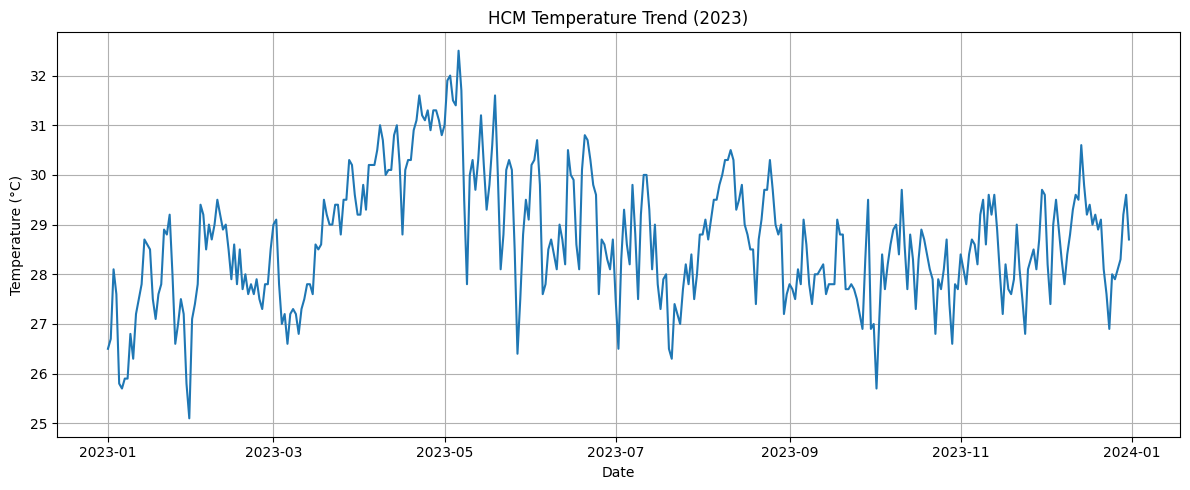

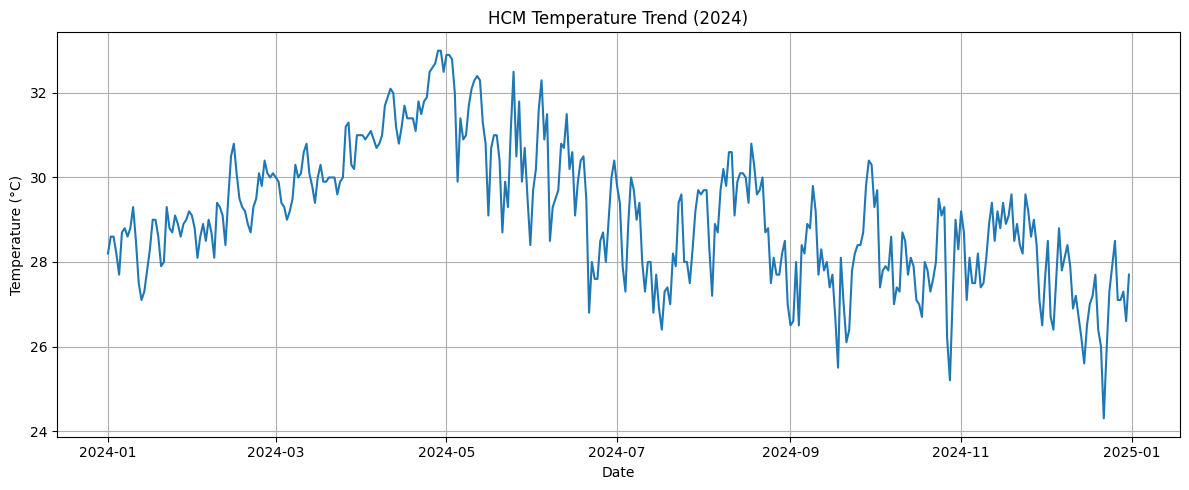

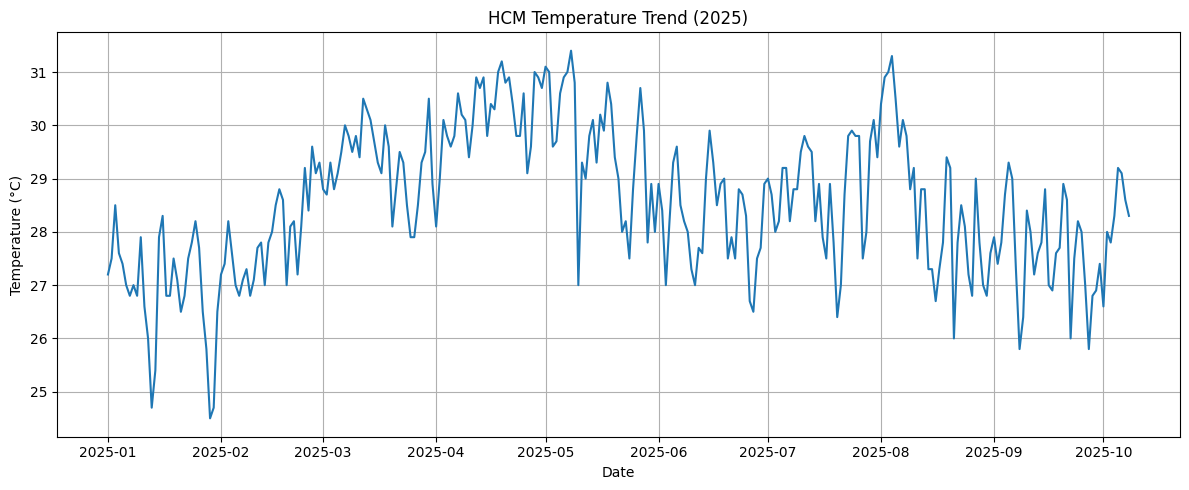

In [16]:
years = range(2015, 2026)

for y in years:
    df_year = df[(df['datetime'] >= f'{y}-01-01') &
                 (df['datetime'] <= f'{y}-12-31')]

    if df_year.empty:
        continue

    plt.figure(figsize=(12,5))
    plt.plot(df_year['datetime'], df_year['temp'])
    plt.title(f"HCM Temperature Trend ({y})")
    plt.xlabel("Date")
    plt.ylabel("Temperature (°C)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [17]:
print(df['temp'].describe())

count    3934.000000
mean       28.451652
std         1.390713
min        22.800000
25%        27.500000
50%        28.400000
75%        29.300000
max        33.000000
Name: temp, dtype: float64


**Comment on HCM trend**

Based on the long-term temperature data from approximately 2015 to 2026 and the detailed chart for 2020, we can draw a basic analysis of Ho Chi Minh City's climate characteristics.

**Overview**

Overall, the data reveals a typical tropical monsoon climate, characterized by a high and stable year-round temperature baseline.

**Key Observations**

**1. A Clear and Cyclical Seasonal Pattern:** The long-term chart displays a consistent year after year. The temperature consistently peaks around April-May, which corresponds to  dry season . Conversely, the temperature reaches its lowest point around December-January, which corresponds to rainy season . The detailed 2020 chart vividly illustrates this cycle.

**2.A Stable Temperature Baseline**  The temperature hovers steadily around a mean of 28.4°C. The low standard deviation of 1.37°C provides statistical evidence for this stability, confirming that temperatures rarely deviate far from the average.

**3.Low Annual Temperature Amplitude:** Due to its proximity to the equator, Ho Chi Minh City receives relatively uniform solar radiation throughout the year.This results in a low annual temperature amplitude (only 6-8C), explaining why the city does not experience distinct cold winters or excessively harsh summers.

**4.Influence of Anomalous Climate Events:** Abnormally sharp temperature spikes (2016, 2023, 2024) strongly correlate with intense global El Niño events.
This indicates that global-scale climate oscillations can temporarily disrupt local climate patterns, leading to hotter and drier conditions in Ho Chi Minh City.

**Conclusion**

In summary, the temperature data paints a clear picture of Ho Chi Minh City's climate: a stable, year-round warm tropical environment without extreme temperature swings. While no significant long-term warming trend is evident within this dataset, the occurrence of extreme heat spikes during El Niño years highlights the local climate's sensitivity to global climate variations.

 **NUMERICAL VARIABLES PLOTS (CORRELATED WITH 'TEMP')**

Top correlations with temp:
 feelslike         0.889542
tempmax           0.841516
tempmin           0.783958
feelslikemin      0.767856
feelslikemax      0.620371
solarradiation    0.581549
solarenergy       0.580570
uvindex           0.473779
visibility        0.409141
humidity          0.342259
Name: temp, dtype: float64

Selected features for plotting: ['feelslike', 'tempmax', 'tempmin', 'feelslikemin', 'feelslikemax', 'solarradiation', 'solarenergy', 'uvindex', 'visibility']


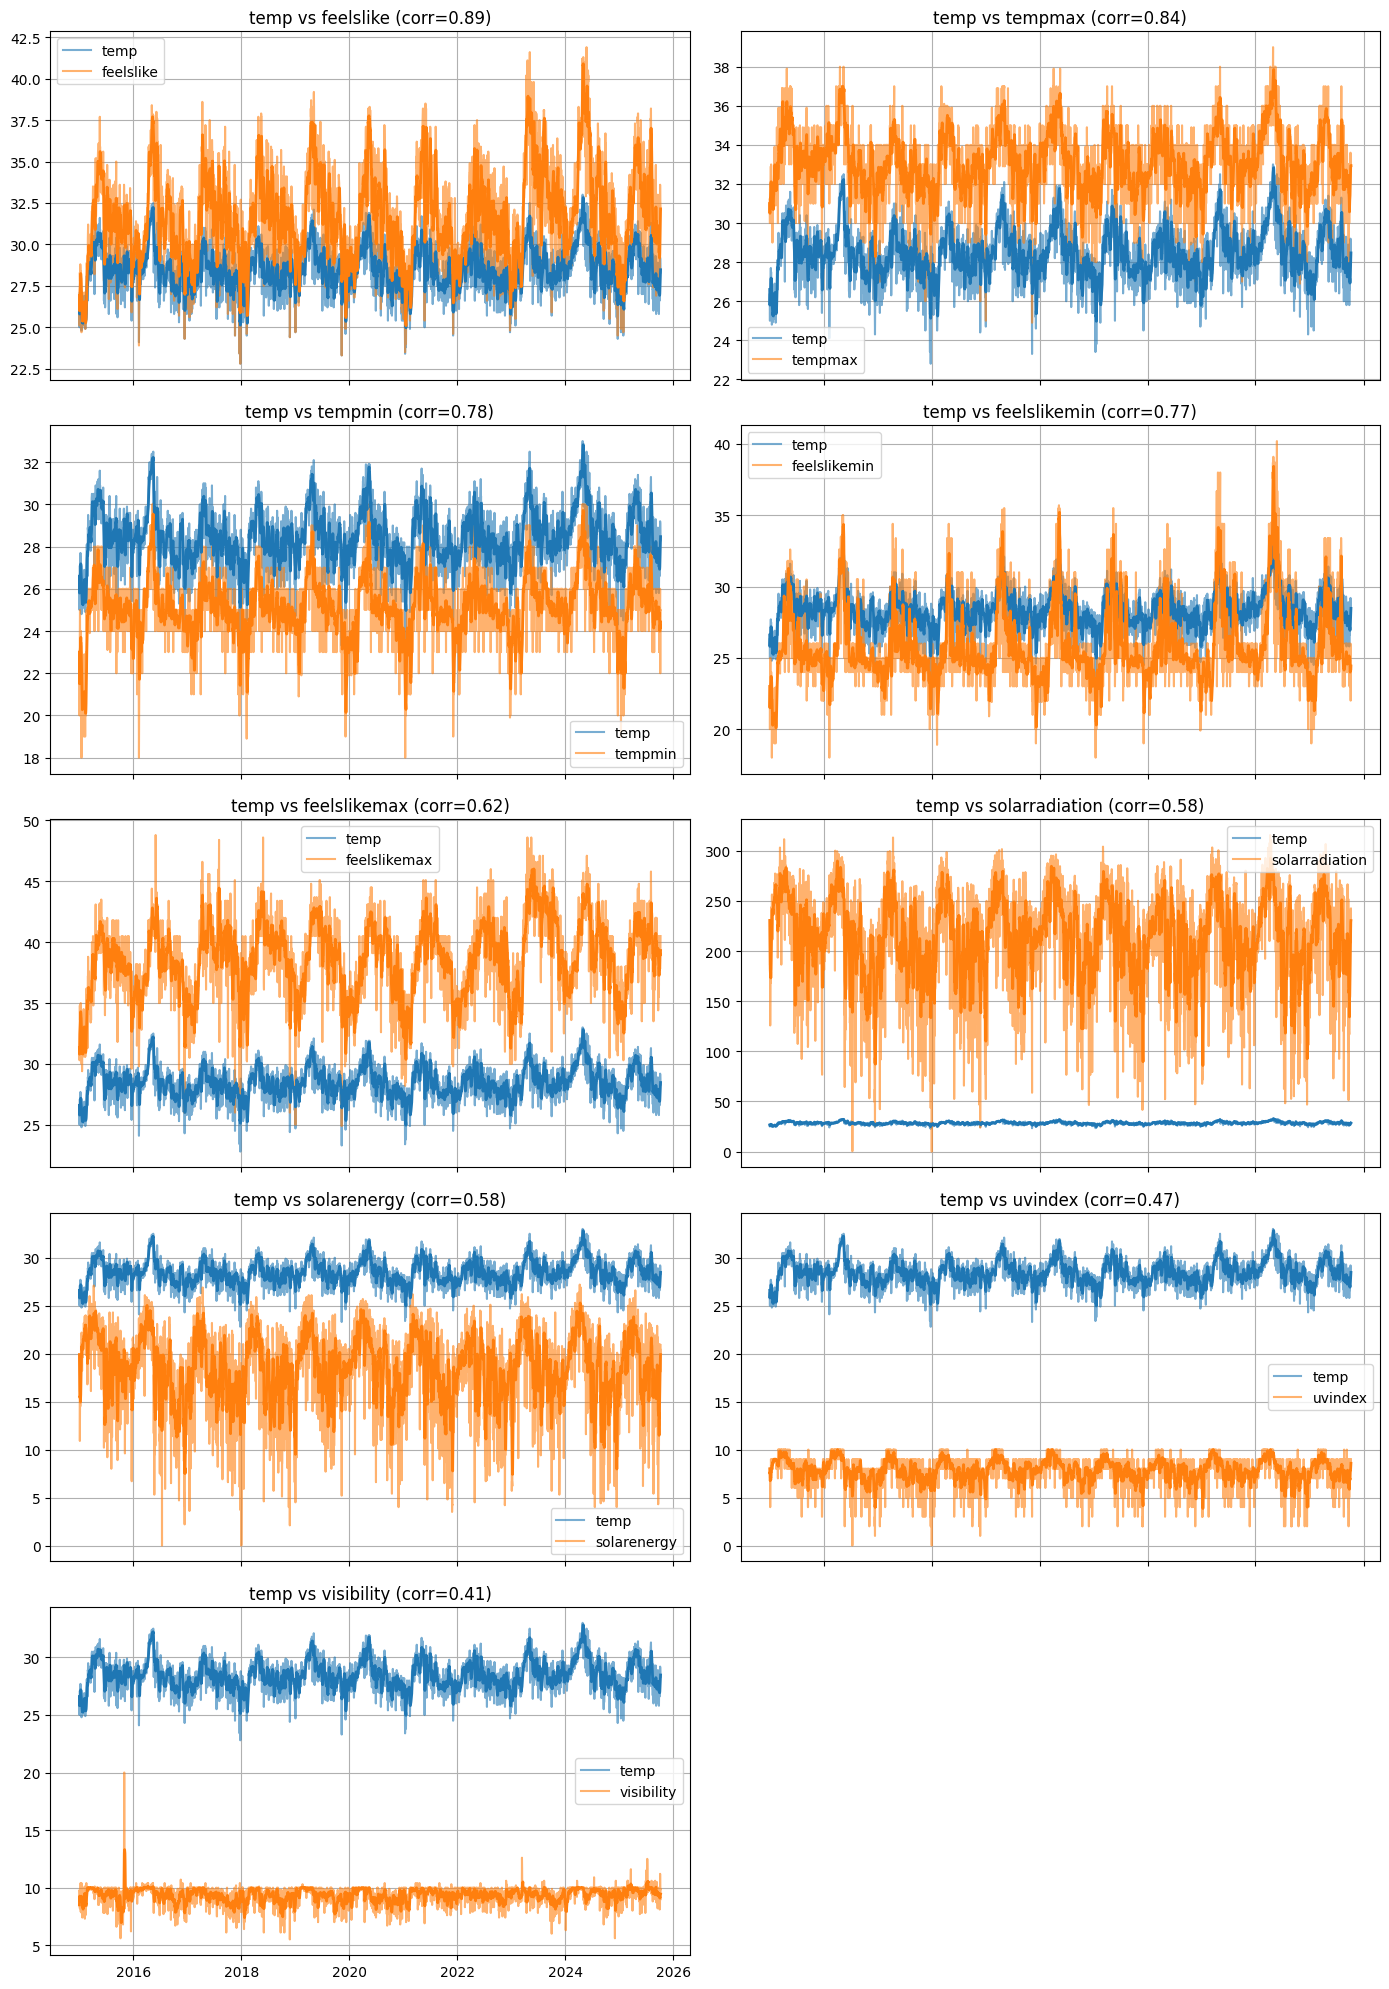

In [18]:
# Find numerical features strongly correlated with 'temp' and plot them over time
import matplotlib.pyplot as plt


if 'datetime' in df.columns:
    df['datetime'] = pd.to_datetime(df['datetime'])
else:
    raise ValueError("Column 'datetime' not found in dataframe")


numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
if 'temp' not in numeric_cols:
    raise ValueError("'temp' column not found among numeric columns. Check column name and types.")


corr_series = df[numeric_cols].corr()['temp'].abs().drop('temp')
corr_series = corr_series.sort_values(ascending=False)
print('Top correlations with temp:\n', corr_series.head(10))

# Select features: threshold or top-k
threshold = 0.4
selected = corr_series[corr_series >= threshold].index.tolist()
if len(selected) == 0:
    # fallback to top 5 if no feature meets threshold
    selected = corr_series.head(5).index.tolist()
print('\nSelected features for plotting:', selected)


if 'datetime' not in df.columns:
    raise ValueError("Column 'datetime' must exist and be convertible to datetime")
df_plot = df.set_index('datetime').sort_index()


n = len(selected)
cols = 1 if n <= 3 else 2
rows = (n + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(14, 4 * rows), sharex=True)


if isinstance(axes, plt.Axes):
    axes = [axes]
else:
    axes = axes.flatten()

for i, feat in enumerate(selected):
    ax = axes[i]

    tmp = df_plot[['temp', feat]].dropna()
    if tmp.empty:
        ax.text(0.5, 0.5, f'No data for {feat}', ha='center')
        continue

    ax.plot(tmp.index, tmp['temp'], label='temp', color='tab:blue', alpha=0.6)
    ax.plot(tmp.index, tmp[feat], label=feat, color='tab:orange', alpha=0.6)
    # 7-day rolling smooth for clarity
    ax.plot(tmp.index, tmp['temp'].rolling(window=7, min_periods=1).mean(), color='tab:blue', linewidth=2)
    ax.plot(tmp.index, tmp[feat].rolling(window=7, min_periods=1).mean(), color='tab:orange', linewidth=2)
    ax.set_title(f"temp vs {feat} (corr={corr_series.loc[feat]:.2f})")
    ax.legend()
    ax.grid(True)


for j in range(i + 1, len(axes)):
    try:
        fig.delaxes(axes[j])
    except Exception:
        pass

plt.tight_layout()
plt.show()


**Comments on Correlation Analysis**

**I. Variables with **STRONG** Influence on TTemp*

- **`tempmax`, `tempmin`, `feelslike`, `feelslikemax`, `feelslikemin`:**  
  These are **direct temperature measures** and have a **very strong positive correlation (≈ +1.0)** with the average temperature.  
   *They are the most important predictive factors.*

- **`dew` (Dew point):**  
  Has a **strong positive correlation**. A high dew point usually comes with **humid air and higher temperatures**, especially important in **Ho Chi Minh City’s climate**.

- **`solarradiation`, `solarenergy`, `uvindex`:**  
  These **solar radiation/energy variables** show a **strong positive correlation**.  
   *The stronger the solar radiation → the higher the average temperature.*

---

**II. Variables with **MODERATE or ADJUSTING** Influence on TTemp**

- **`humidity`:**  
  Shows a **weak to moderate positive correlation**.  
  High humidity often comes with warm weather, but the **relationship is not as linear** as dew point.

- **`precipprob`, `precipcover`:**  
  Show a **weak negative correlation**.  
   *Rain usually lowers the average temperature.*

- **`cloudcover`:**  
  Has a **weak negative correlation** with solar radiation.  
  More clouds → less sunlight → lower daytime temperature, **but sometimes retains heat at night.**

---

**III. Variables with **WEAK or INSIGNIFICANT** Influence on Temp**

- **`windgust`, `windspeed`, `winddir`:**  
  Have a **very weak correlation**. Although they affect **the perceived temperature**, their **direct relationship with average temperature is minimal.**

- **`sealevelpressure`, `visibility`:**  
  Also show a **very weak correlation**.

- **`moonphase`, `snow`, `snowdepth`, `severerisk`:**  
  Almost **no correlation** — which is **completely reasonable for Ho Chi Minh City’s climate**.

---

**Conclusion: Combining Variables to Predict Average Temperature**

- **Strongest Predictors:**
The variables `tempmax`, `tempmin`, `feelslike`, `feelslikemax`, `feelslikemin`, `dew`, `solarradiation`, `solarenergy`, and `uvindex `show very strong positive correlations with temperature.
→ These represent the core thermal and solar dynamics that drive daily temperature variations.

- **Moderate Influences:**
Factors such as `humidity`, `precipprob`, `precipcover`, and `cloudcover` exhibit moderate or adjusting effects — they influence temperature indirectly through `moisture`, `rainfall`, and `sunlight blockage`.

- **Weak or Insignificant Variables:**
`windgust`, `windspeed`, `winddir`, `sealevelpressure`, and `visibility` show minimal correlation, while `moonphase`, `snow`,` snowdepth`, and `severerisk` are nearly irrelevant in the city’s tropical climate.


**CATEGORICAL VARIABLES PLOTS**



------------------------------------------------------------
Column: preciptype


,preciptype,count,pct
0,rain,3013,76.59%
1,Missing,921,23.41%


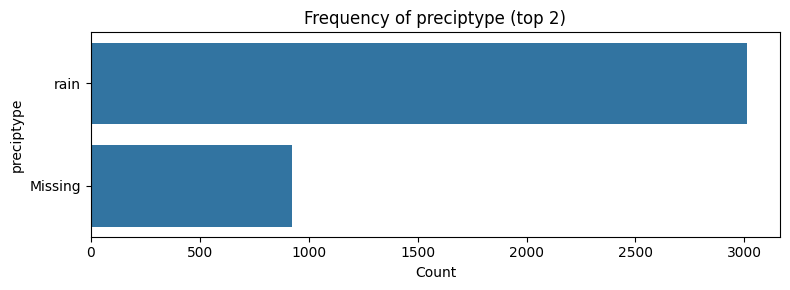

------------------------------------------------------------
Column: conditions


,conditions,count,pct
0,"Rain, Partially cloudy",2975,75.62%
1,Partially cloudy,933,23.72%
2,"Rain, Overcast",16,0.41%
3,Clear,10,0.25%


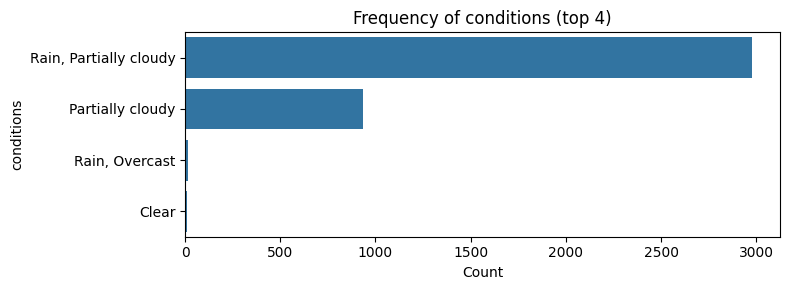

------------------------------------------------------------
Column: icon


,icon,count,pct
0,rain,2991,76.03%
1,partly-cloudy-day,933,23.72%
2,clear-day,10,0.25%
3,Missing,0,0.00%


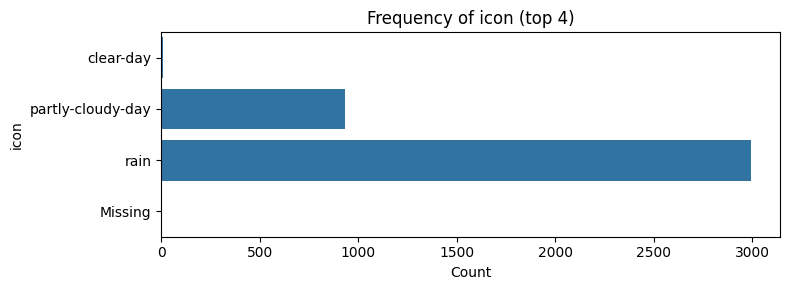

In [22]:
# Plot frequency charts for selected categorical variables
cat_cols = ['preciptype', 'conditions', 'icon']
existing = [c for c in cat_cols if c in df.columns]

if len(existing) == 0:
    print('None of the requested categorical columns found in dataframe:', cat_cols)
else:

    default_blue = plt.rcParams['axes.prop_cycle'].by_key()['color'][0]

    for col in existing:
        print('-' * 60)
        print(f'Column: {col}')

        if df[col].dtype.name == 'category' and 'Missing' not in df[col].cat.categories:
            df[col] = df[col].cat.add_categories(['Missing'])

        vc = df[col].fillna('Missing').value_counts()
        pct = 100 * vc / len(df)

        freq_df = pd.DataFrame({'count': vc, 'pct': pct}).reset_index().rename(columns={'index': col})
        display(freq_df.head(20).style.format({'pct': '{:.2f}%'}))

        top_n = min(20, len(vc))

        # Plot với màu xanh như plt.barh()
        plt.figure(figsize=(8, max(3, 0.35 * top_n)))
        sns.barplot(
            x=vc.values[:top_n],
            y=vc.index[:top_n],
            color=default_blue  # ⬅ đúng màu xanh của Matplotlib
        )

        plt.xlabel('Count')
        plt.title(f'Frequency of {col} (top {top_n})')
        plt.tight_layout()
        plt.show()

**Interpretation of Categorical Frequency Plots**

Below are the observations and interpretations of the frequency plots for `preciptype`, `conditions`, and `icon` in the context of predicting `temp`:

1) **`preciptype` (Type of Precipitation):**  
- If most values are `rain` or `Missing`, it indicates that rainy days dominate the dataset or that the precipitation type has low variability.  
- **Implication:** Rainy days are usually associated with cloud cover and reduced solar radiation, leading to lower average daily `temp`.  
  Therefore, `preciptype` is a useful variable but often correlated with `precip`, `precipcover`, and `cloudcover` (potential redundancy).

2) **`conditions` (Weather Conditions):**  
- This variable typically includes labels such as `Clear`, `Partly Cloudy`, `Rain`, `Overcast`, etc. The frequency plot shows the distribution of these labels.  
- **Implication:** The `Clear` label generally corresponds to higher solar radiation and higher temperatures, while `Rain` or `Overcast` corresponds to lower temperatures.  
  This variable has strong descriptive power and interpretability; after preprocessing (e.g., grouping rare labels into `Other`, filling `Missing`), it is suitable for encoding (one-hot or target encoding).

3) **`icon` (Weather Icon):**  
- The `icon` variable usually contains short symbolic representations similar to `conditions` (e.g., `rain`, `clear-day`). The frequency plot shows the common icons.  
- **Implication:** `icon` is a simplified version of weather conditions and can be used as an alternative or complement to `conditions`.  
  If both exist, consider keeping only one to avoid redundancy.

4) **Importance in Temperature Prediction Models:**  
- These variables often serve as auxiliary features with physical meaning (cloud/rain → affects solar radiation → affects `temp`).  
  They perform best when combined with continuous variables like `solarradiation`, `dew`, `humidity`, and temporal/lag features (e.g., `temp_lag_1`, `temp_roll_mean_7`).  
- If the plot shows that a specific category (e.g., `Rain`) occurs rarely but has a strong impact on `temp` when present, **keep that category** — it provides important predictive signals.

**In summary:**  
These categorical variables can enhance temperature forecasting performance if properly handled (grouping rare labels, keeping `Missing`, using appropriate encoding) and combined with continuous and temporal features.


# DATA PROCESSING

**DATA QUALITY CHECKS**

This is the most critical phase where we clean the data, handle issues, and create new, more informative features to improve model performance.

**Data Quality: Missing Values and Duplicates**

First, we check for missing data and duplicate rows.
*   **Missing Values:** Can cause errors or lead to biased models if not handled correctly.
*   **Duplicates:** Can artificially inflate the importance of certain data points and skew results.# **DATA QUALITY CHECKS**

This is the most critical phase where we clean the data, handle issues, and create new, more informative features to improve model performance.

**Data Quality: Missing Values and Duplicates**

First, we check for missing data and duplicate rows.
*   **Missing Values:** Can cause errors or lead to biased models if not handled correctly.
*   **Duplicates:** Can artificially inflate the importance of certain data points and skew results.

**CHECK MISSING VALUE**

Columns with NaN values and their percentages:
----------------------------------------------------------------------------------------------------


,column,percent
25,severerisk,65.226233
13,preciptype,23.411286


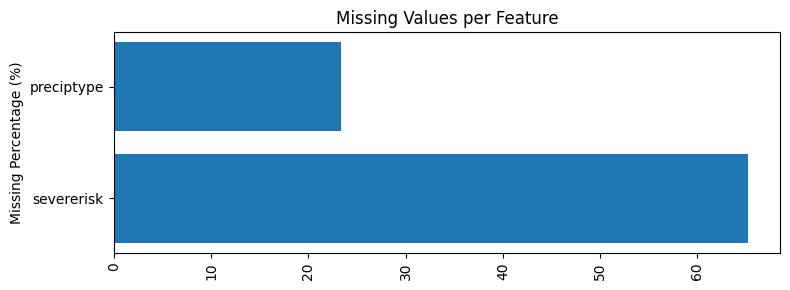

In [20]:
def nan_df_create(data):
    nan_percentages = data.isna().sum() * 100 / len(data)
    df = pd.DataFrame({'column' : nan_percentages.index, 'percent' : nan_percentages.values})
    df.sort_values(by = 'percent', ascending = False, inplace = True)
    return df

print("Columns with NaN values and their percentages:")
print('-'*100)
data_nan = nan_df_create(df)
data_nan_nonzero = data_nan[data_nan.percent > 0]
display(data_nan_nonzero)

plt.figure(figsize=(8, 3))
plt.barh(data_nan_nonzero['column'], data_nan_nonzero['percent'])
plt.xticks(rotation=90)
plt.ylabel("Missing Percentage (%)")
plt.title("Missing Values per Feature")
plt.tight_layout()
plt.show()

del data_nan


Do One-hot encode preciptype to has_rain (rain=1, NaN/others=0)

In [33]:
df['has_rain'] = (
    df['preciptype']
    .astype(str)
    .fillna('')
    .str.lower()
    .str.contains('rain')
    .astype(int)
)

df.drop(columns=['preciptype'], inplace=True)

**CHECK DUPLICATES**

In [23]:
dup_count = df.duplicated(keep='first').sum()
print(f'Number of duplicate rows (exact duplicates): {dup_count}')

Number of duplicate rows (exact duplicates): 0


**REMOVING IRRELEVANT COLUMNS AND HANDLING MISSING DATA**  
Because`severerisk` had about 70% missing data and low predictive value → removed.


In [24]:
df.drop(columns = ['severerisk'], inplace = True)
df.drop(columns = ['description'], inplace = True)

**Drop unnecessary columns from the dataframe**  
Since snow never occurs in Ho Chi Minh City, we remove the `snow` and `snowdepth` columns

In [29]:
columns_to_drop = ['icon', 'description', 'stations', 'name', 'snow', 'snowdepth']
df.drop(columns=columns_to_drop, inplace=True, errors='ignore')

**UNIT CONVERSION**
We perform standardization and conversion of meteorological measurement units to the Metric system. This ensures consistency and accuracy for subsequent model building processes

| Feature | Conversion |
|------|-------------------|
| precipin (inches) | → mm (millimeters) |
| humidity, cloudcover, precipprob, precipcover | Percentage (%) → Fraction (0.0 to 1.0) |
| windspeed, windgust | mph (miles per hour) → m/s (meters per second) |
| visibilitymi | miles → km (kilometers) |
| solarenergy | MJ/m²/day → W/m²-equivalent |


In [26]:
df['precip'] = df['precip'] * 25.4

pct_cols = ['humidity','cloudcover','precipprob','precipcover']
df[pct_cols] = df[pct_cols] / 100.0

wind_cols = ['windspeed','windgust']
df[wind_cols] = df[wind_cols] / 2.237

df['visibility'] = df['visibility'] * 1.609

df['solarenergy_wm2eq'] = df['solarenergy'] * 11.6

**ENCODING FOR " CONDITION" COLUMN**
This code processes the categorical column conditions, which contains text-based weather states that the model cannot read directly. It applies the One-Hot Encoding technique to create new columns for each distinct weather condition (e.g., condition_Sunny, condition_Rainy), assigning a value of 1 if the condition is present and 0 if not.

In [27]:
# One-hot encode the 'conditions' column
conditions_dummies = pd.get_dummies(df['conditions'], prefix='condition', dummy_na=True)
df = pd.concat([df, conditions_dummies], axis=1)

# Optional: drop the original 'conditions' column
df.drop(columns=['conditions'], inplace=True)

# **FEATURE ENGINEERING**

In this project, our primary goal is to use physical variables and other meteorological indicators to capture and predict the underlying temperature trends in a robust manner.

**Dropping Redundant & Target-Leaking Features**

To build a robust forecasting model, we must remove features that would not be available at the time of prediction (target leakage) or are highly redundant.

*   **Target Leakage:** Features like `tempmax`, `tempmin`, `feelslike`, `feelslikemax`, and `feelslikemin` are directly calculated from or are variations of the mean `temp`. Including them would make the model seem perfect during training but fail in a real-world scenario.
*   **Redundancy:** The `description` column provides text details already captured by the `conditions` and `icon` columns.

We will drop these columns to ensure our model learns from true physical drivers.

In [ ]:
drop_cols = ['feelslike', 'feelslikemax', 'feelslikemin', 'tempmax', 'tempmin']
df = df.drop(columns=[c for c in drop_cols if c in df.columns], errors='ignore')

**We perform the calculation of `day_length` to derive a crucial seasonal predictor by quantifying the hours between sunset and sunrise.**

In [ ]:
df['day_length'] = (
    (df['sunset'] - df['sunrise'])
    .dt.total_seconds()
    .div(3600)
    .clip(lower=0, upper=24)
)
df.drop(columns = ['sunrise','sunset'], inplace = True)


**Physics-Based and Interaction Features**
These features combine existing variables to represent more complex physical phenomena.
*   **Solar & Moisture:** `radiation_efficiency`, `rad_per_hour`, `dew_humidity_ratio` help quantify the relationship between sun, clouds, and humidity.
*   **Wind & Storms:** Wind direction is decomposed into `wind_u` (East-West) and `wind_v` (North-South) components. A `storminess` index is also created.
*   **Monsoon Indicators:** We create flags to explicitly signal the Southwest (`sw_monsoon_flag`) and Northeast (`ne_monsoon_flag`) monsoon seasons, which are the primary climate drivers in Ho Chi Minh City.

**Rolling, Lag, and Trend Features**
To give the model a sense of "memory," we create features that describe trends over time.
*   **Rolling Statistics:** We calculate the mean and variance of key features (like wind and pressure) over 7 and 28-day windows. This helps the model understand the recent weather regime (e.g., a stable high-pressure week vs. a volatile one).
*   **EWMA (Exponentially Weighted Moving Average):** This captures recent momentum by giving more weight to newer data, helping the model react more quickly to changing trends.
*   **Gradients (Differences):** Day-over-day changes in pressure and humidity are calculated to detect the arrival of new air masses or fronts.

In [ ]:
df['radiation_efficiency'] = (
    (df['solarradiation'] + 0.1 * df['solarenergy'])
    / (df['cloudcover'].clip(lower=1) + 1e-3)
)
df['rad_per_hour'] = df['solarenergy'] / (df['day_length'] + 1e-3)

df['dew_humidity_ratio'] = df['dew'] / df['humidity'].replace(0, np.nan)
df['dew_humidity_ratio'] = df['dew_humidity_ratio'].fillna(0)

df['precip_intensity'] = (
    df['precip'] / (df['precipcover'].replace(0, np.nan) + 1e-3)
).clip(upper=100)

df['wind_u'] = df['windspeed'] * np.cos(np.deg2rad(df['winddir']))
df['wind_v'] = df['windspeed'] * np.sin(np.deg2rad(df['winddir']))

df['wind_u'] -= df['wind_u'].mean()
df['wind_v'] -= df['wind_v'].mean()

df['storminess'] = (df['windspeed'] ** 2) * (df['precipprob'] / 100.0)

df['dayofyear'] = df['datetime'].dt.dayofyear
df['doy_sin'] = np.sin(2 * np.pi * df['dayofyear'] / 365.25)
df['doy_cos'] = np.cos(2 * np.pi * df['dayofyear'] / 365.25)


**Advanced Feature Engineering**

**Objective:** *To provide the model with atmospheric context and memory of trends, rather than relying solely on the instantaneous values of a single day. These features are grouped into 6 main categories:*

---

**1.Rolling Features & Lags — Trends and Stability**

**Purpose:** *To give the model short- and mid-term trends instead of just isolated daily snapshots.*

-   `wind_u_mean_w7`, `wind_v_mean_w7` (and w28)
    -   **What:** 7/28-day rolling means for wind components.
    -   **→ Why:** Indicates the prevailing wind pattern and its consistency, which strongly influences temperature and humidity advection.

-   `wind_u_var_w7`, `wind_v_var_w7` (and w28)
    -   **What:** Rolling variance of wind components.
    -   **→ Why:** Measures instability/turbulence. **High variance** suggests changing conditions (storms/gusts), while **low variance** indicates a stable regime.

---

**2.Pressure & Humidity Gradients — Dynamic Changes**

**Purpose:** *To detect fronts and the movement of air masses.*

-   `pressure_change_1d`, `humidity_change_1d`, `dew_change_1d`
    -   **What:** Day-over-day difference (`diff(1)`).
    -   **→ Why:** A sharp drop in pressure signals an approaching front/storm; a change in humidity/dew indicates a new air mass is arriving.

-   `pressure_mean_w7`, `humidity_mean_w7` (and their `_var`)
    -   **What:** 7-day rolling mean and variance.
    -   **→ Why:** Helps distinguish the current atmospheric regime (high-pressure/low-pressure; dry/humid).

---

**3.Climate & Regime Indicators — Seasonal Signals & Long-Term Rules**

**Purpose:** *To provide seasonal rhythms and climate drivers that cannot be learned from just a few days of data.*

-   `is_wet_season`, `season_progress`
    -   **What:** Encodes the season (e.g., wet/dry) and its progression (0→1).
    -   **→ Why:** Helps the model understand the annual cycle (critical in Ho Chi Minh City).

-   `soil_wetness_index`
    -   **What:** 14-day cumulative rainfall (`wet14`) passed through an exponential function — a proxy for soil moisture.
    -   **→ Why:** Wet soil impacts T_min via evapotranspiration; provides a "memory" of recent rainfall.

-   `sw_monsoon_flag`, `ne_monsoon_flag`, `wind_monsoon_index`
    -   **What:** Flags based on wind direction to encode the main monsoon season.
    -   **→ Why:** Directly informs the model about the monsoon regime, which dictates moisture and heat.

---

**4.Low-Noise Categorical Patterns — Low-Noise Flags/Labels**

**Purpose:** *To convert noisy, continuous variables into clean, interpretable events for the model to learn.*

-   `is_onshore_flow` / `is_offshore_flow`
    -   **What:** Wind from the sea or from land.
    -   **→ Why:** Onshore → humid, moderates temperature; offshore → hot & dry.

-   `cloudy_spell_flag` / `clear_spell_flag`
    -   **What:** Flag based on 7-day mean cloud cover > threshold.
    -   **→ Why:** Distinguishes a single cloudy day (noise) from a persistent cloudy spell (which impacts radiation).

-   `is_convective_rain` / `is_stratiform_rain`
    -   **What:** Classifies rain based on intensity and wind.
    -   **→ Why:** These two rain types have different mechanisms and impacts on temperature/humidity.

-   `regime_hot_humid`, `regime_hot_drier`, …
    -   **What:** Groups days based on median thresholds of humidity & radiation.
    -   **→ Why:** Helps models (especially tree-based ones) learn complex interactions.

---

**5.Advanced Physical-Coherence Features — Physical Correlation & Consistency**

**Purpose:** *To measure the interaction between variables and the physical consistency of the atmospheric field.*

-   `wind_dir_consistency_w7` & `w28`
    -   **What:** A 0–1 index measuring wind direction stability over 7/28 days.
    -   **→ Why:** **High** = stable air mass; **Low** = unstable, changing conditions.

-   `wind_pressure_coupling`
    -   **What:** Wind speed × short-term pressure gradient (e.g., 3d−7d).
    -   **→ Why:** A proxy for pressure-driven advection: strong wind + rapid pressure change → weather change.

-   `{a}_{b}_cov7`
    -   **What:** 7-day rolling covariance between pairs of variables (e.g., humidity & solarradiation).
    -   **→ Why:** Tells the model if two variables tend to move together or in opposition over a week.

-   `mean_wind_dir_w7_sin` & `_cos`
    -   **What:** Encodes wind direction angle as sin/cos.
    -   **→ Why:** Correctly handles the cyclical nature of angles (359° ≈ 1°).

-   `wind_energy_anom`
    -   **What:** Wind energy (0.5*v^2) minus its 56-day mean (anomaly).
    -   **→ Why:** Highlights how unusual today's wind is compared to the long-term baseline—often a predictor of change.

---

**6.EWMA (Exponentially Weighted Moving Average)**

**Purpose:** *To capture recent momentum by giving more weight to newer data.*

-   **Applied to 6 key variables:** `humidity`, `dew`, `solarradiation`, `sealevelpressure`, `windspeed`, `precip`.
-   **Uses three configurations:** 3d, 7d, 14d (short → medium → long).
    -   **→ Why:** EWMA is more sensitive to recent changes than a simple moving average, helping to catch newly emerging "momentum" signals.

---

**Brief Conclusion**

These features transform "single-day" data into **short-, medium-, and long-term weather context and memory**.

They provide the model with:
-   **Trends and instability**
-   **Fronts and seasonal patterns**
-   **Rain types and physical interactions**
-   **Anomalies**

All of these are crucial factors that improve predictive power far beyond what can be learned from daily values alone. The organizational structure (rolling, gradient, regime, coherence, EWMA) allows both linear and tree-based models to learn the physical mechanisms and repeating patterns within the data.

In [ ]:
# ROLLING /  LAGS
# ---------------------------------------------------------------
for w in [7, 28]:
    df[f'wind_u_mean_w{w}'] = df['wind_u'].rolling(w, 1).mean()
    df[f'wind_v_mean_w{w}'] = df['wind_v'].rolling(w, 1).mean()
    df[f'wind_u_var_w{w}']  = df['wind_u'].rolling(w, 1).var()
    df[f'wind_v_var_w{w}']  = df['wind_v'].rolling(w, 1).var()

In [ ]:
# PRESSURE & HUMIDITY GRADIENTS
# ---------------------------------------------------------------
df['pressure_change_1d'] = df['sealevelpressure'].diff(1)
df['humidity_change_1d'] = df['humidity'].diff(1)
df['dew_change_1d']      = df['dew'].diff(1)

for w in [7, 28]:
    df[f'pressure_mean_w{w}'] = df['sealevelpressure'].rolling(w,1).mean()
    df[f'pressure_var_w{w}']  = df['sealevelpressure'].rolling(w,1).var()
    df[f'humidity_mean_w{w}'] = df['humidity'].rolling(w,1).mean()
    df[f'humidity_var_w{w}']  = df['humidity'].rolling(w,1).var()

In [ ]:
#  CLIMATE & REGIME INDICATORS
# ---------------------------------------------------------------
m = df['datetime'].dt.month
df['is_wet_season']   = m.isin([5,6,7,8,9,10]).astype(int)
df['season_progress'] = np.where(m < 5, 0, np.where(m > 10, 1, (m-5)/5.0))

wet14 = df['precip'].rolling(14,1).sum()
df['soil_wetness_index'] = 1 - np.exp(-0.05 * wet14)

df['sw_monsoon_flag'] = (df['wind_v'] > 0).astype(int)
df['ne_monsoon_flag'] = (df['wind_v'] < 0).astype(int)
df['wind_monsoon_index']     = 0.7*df['wind_u'] + 0.7*df['wind_v']
df['wind_monsoon_weighted']  = df['wind_monsoon_index'] * df.get('doy_sin',1.0)

In [ ]:
# LOW-NOISE CATEGORICAL PATTERNS
# ---------------------------------------------------------------
sea_sector = (df['winddir'] >= 90) & (df['winddir'] <= 210)
df['is_onshore_flow']  = sea_sector.astype(int)
df['is_offshore_flow'] = (~sea_sector).astype(int)

cloud7 = df['cloudcover'].rolling(7,1).mean()
df['cloudy_spell_flag'] = (cloud7 > 0.7).astype(int)
df['clear_spell_flag']  = (cloud7 < 0.3).astype(int)

df['precip_intensity'] = df['precip'] / (df['precipcover'] + 1e-3)
df.loc[df['precip']==0, 'precip_intensity'] = 0
med_intensity = df['precip_intensity'].median()
med_gust      = df['windgust'].median()
df['is_convective_rain'] = ((df['precip_intensity'] > med_intensity) &
                            (df['windgust'] > med_gust)).astype(int)
df['is_stratiform_rain'] = ((df['precip'] > 0) &
                            (df['is_convective_rain']==0)).astype(int)
df['convective_yesterday'] = df['is_convective_rain'].shift(1).fillna(0)

hum_thr = df['humidity'].median()
rad_thr = df['solarradiation'].median()
df['regime_hot_humid']    = ((df['humidity'] > hum_thr) & (df['solarradiation'] > rad_thr)).astype(int)
df['regime_hot_drier']    = ((df['humidity'] < hum_thr) & (df['solarradiation'] > rad_thr)).astype(int)
df['regime_cloudy_humid'] = ((df['humidity'] > hum_thr) & (df['solarradiation'] < rad_thr)).astype(int)

In [ ]:
# ADVANCED PHYSICAL-COHERENCE FEATURES
# ---------------------------------------------------------------
u, v = df['wind_u'], df['wind_v']
df['wind_dir_consistency_w7']  = np.sqrt(u.rolling(7,1).mean()**2 + v.rolling(7,1).mean()**2) / (
                                  df['windspeed'].rolling(7,1).mean() + 1e-3)
df['wind_dir_consistency_w28'] = np.sqrt(u.rolling(28,1).mean()**2 + v.rolling(28,1).mean()**2) / (
                                  df['windspeed'].rolling(28,1).mean() + 1e-3)

df['wind_pressure_coupling'] = df['windspeed'] * (
    df['sealevelpressure'].rolling(3,1).mean() - df['sealevelpressure'].rolling(7,1).mean()
)

df['humid_radiation_balance'] = df['humidity'].rolling(3,1).mean() * df['solarradiation'].rolling(3,1).mean()
df['humid_radiation_ratio']   = df['humidity'] / (df['solarradiation'] + 1e-3)

if 'rain_risk_combo_w7' in df.columns:
    df['rain_risk_trend_3d'] = df['rain_risk_combo_w7'] - df['rain_risk_combo_w7'].shift(3)
    df['rain_risk_yesterday'] = df['rain_risk_combo_w7'].shift(1)
else:
    df['rain_risk_trend_3d'] = 0
    df['rain_risk_yesterday'] = 0

pairs = [('humidity','solarradiation'),
         ('wind_u','wind_v'),
         ('humidity','precip'),
         ('sealevelpressure','windspeed')]
for a,b in pairs:
    df[f'{a}_{b}_cov7'] = df[a].rolling(7,1).cov(df[b])

df['mean_wind_dir_w7']  = np.rad2deg(np.arctan2(df['wind_v_mean_w7'],  df['wind_u_mean_w7']))  % 360
df['mean_wind_dir_w28'] = np.rad2deg(np.arctan2(df['wind_v_mean_w28'], df['wind_u_mean_w28'])) % 360
df['mean_wind_dir_w7_rad']  = np.deg2rad(df['mean_wind_dir_w7'])
df['mean_wind_dir_w28_rad'] = np.deg2rad(df['mean_wind_dir_w28'])
df['mean_wind_dir_w7_sin']  = np.sin(df['mean_wind_dir_w7_rad'])
df['mean_wind_dir_w7_cos']  = np.cos(df['mean_wind_dir_w7_rad'])
df['mean_wind_dir_w28_sin'] = np.sin(df['mean_wind_dir_w28_rad'])
df['mean_wind_dir_w28_cos'] = np.cos(df['mean_wind_dir_w28_rad'])

bins = np.arange(-22.5, 382.5, 45)
labels = ['N','NE','E','SE','S','SW','W','NW']
df['wind_sector_w7_cat']  = pd.cut(df['mean_wind_dir_w7'],  bins=bins, labels=labels, ordered=False)
df['wind_sector_w28_cat'] = pd.cut(df['mean_wind_dir_w28'], bins=bins, labels=labels, ordered=False)

df['precip_efficiency'] = df['precip'].rolling(3,1).sum() / (df['cloudcover'].rolling(3,1).mean() + 1e-3)
df['wind_energy']      = 0.5 * (df['windspeed'] ** 2)
df['wind_energy_anom'] = df['wind_energy'] - df['wind_energy'].rolling(56,1).mean()
df['convective_potential_index'] = df['humidity'].rolling(7,1).mean() * df['solarradiation'].rolling(7,1).mean()

In [ ]:
# EWMA
# ---------------------------------------------------------------
ewma_features = ['humidity', 'dew', 'solarradiation', 'sealevelpressure', 'windspeed', 'precip']
ewma_configs = {
    '3d': 0.5,
    '7d': 0.3,
    '14d': 0.15
}
for col in ewma_features:
    for tag, alpha in ewma_configs.items():
        df[f'{col}_ewma_{tag}'] = df[col].ewm(alpha=alpha, adjust=False).mean()

In [ ]:
windows = [3, 7, 14, 28, 56]

# Drop optional categorical sectors before training
cat_cols = [c for c in df.columns if c.endswith('_cat')]
df = df.drop(columns=cat_cols, errors='ignore')

# Fill NaN numerics
num_cols = df.select_dtypes(include=['number']).columns
df[num_cols] = df[num_cols].fillna(0)

df = df.iloc[max(windows):].reset_index(drop=True)

# **TARGET AND SPLIT**

We splits the data chronologically into an 80% training set and a 20% testing set for unbiased evaluation. Then, we separate the input features  from the target temperature for both sets, creating X_train, y_train, X_test, and y_test to be used for model training and validation.

In [ ]:
# Define the prediction target
df['target'] = df['temp'].shift(-1)
df = df.dropna(subset=['target']).reset_index(drop=True)

#Train/Test split (8:2)
split_idx = int(len(df) * 0.8)
train = df.iloc[:split_idx].copy()
test  = df.iloc[split_idx:].copy()

exclude_cols = ['datetime', 'target', 'temp']
feature_cols = [c for c in df.columns if c not in exclude_cols]

X_train, y_train = train[feature_cols], train['target']
X_test,  y_test  = test[feature_cols],  test['target']

print(f"Train shape: {X_train.shape} | Test shape: {X_test.shape}")
print(f"Feature count: {len(feature_cols)}")
print('-'*100)
print(f"Train period: {train['datetime'].min()} → {train['datetime'].max()}")
print(f"Test period : {test['datetime'].min()} → {test['datetime'].max()}")

Train shape: (3101, 115) | Test shape: (776, 115)
Feature count: 115
----------------------------------------------------------------------------------------------------
Train period: 2015-02-26 00:00:00 → 2023-08-23 00:00:00
Test period : 2023-08-24 00:00:00 → 2025-10-07 00:00:00


# **TRAIN MODEL**

**FEATURE GROUP INSPECTION**

In [ ]:
groups = [
    'wind', 'precip', 'humidity', 'radiation', 'pressure',
    'dew', 'cloud', 'visibility', 'season', 'soil', 'regime',
    'energy', 'storm', 'rain', 'monsoon', 'dir', 'change',
    'index', 'flux', 'balance', 'ratio', 'consistency'
]
print(f"\nTotal features: {len(df.columns)}")

for g in groups:
    cols = [c for c in df.columns if g in c]
    if len(cols) > 0:
        print(f"\n{'-'*80}\n {g.upper()} ({len(cols)} features)")
        for c in cols:
            print("   ", c)


Total features: 118

--------------------------------------------------------------------------------
 WIND (33 features)
    windgust
    windspeed
    winddir
    wind_u
    wind_v
    wind_u_mean_w7
    wind_v_mean_w7
    wind_u_var_w7
    wind_v_var_w7
    wind_u_mean_w28
    wind_v_mean_w28
    wind_u_var_w28
    wind_v_var_w28
    wind_monsoon_index
    wind_monsoon_weighted
    wind_dir_consistency_w7
    wind_dir_consistency_w28
    wind_pressure_coupling
    wind_u_wind_v_cov7
    sealevelpressure_windspeed_cov7
    mean_wind_dir_w7
    mean_wind_dir_w28
    mean_wind_dir_w7_rad
    mean_wind_dir_w28_rad
    mean_wind_dir_w7_sin
    mean_wind_dir_w7_cos
    mean_wind_dir_w28_sin
    mean_wind_dir_w28_cos
    wind_energy
    wind_energy_anom
    windspeed_ewma_3d
    windspeed_ewma_7d
    windspeed_ewma_14d

--------------------------------------------------------------------------------
 PRECIP (9 features)
    precip
    precipprob
    precipcover
    precip_intensity
    hu

**FEATURE SELECTION**

To improve the temperature forecasting model, we applied a two-step feature selection method that focuses on keeping only the most informative meteorological variables.

**Step 1: Mutual Information (MI) Filtering**
- Compute **Mutual Information** between each feature \( X_i \) and target \( y \):

$$
MI(X_i, y) = \sum_{x \in X_i} \sum_{y \in Y} p(x, y) \log \frac{p(x, y)}{p(x)p(y)}
$$

where \( p(x, y) \) is the joint probability of \( X_i \) and \( y \), and \( p(x) \), \( p(y) \) are the marginal probabilities.

- Rank all features by MI score.
- Retain **top 25% features**:

$$
X_{\text{MI}} = \{ X_i \,|\, MI(X_i, y) > \text{75th percentile of MI scores} \}
$$

> Removes features with little predictive information, reducing noise and dimensionality.

**Step 2: XGBoost Feature Ranking by Families**
- Train a lightweight **XGBoost Regressor** on \( X_{\text{MI}} \):

$$
y = f_{\text{XGB}}(X_{\text{MI}}) + \epsilon
$$

- Extract **feature importance** for each feature \( X_i \):

$$
\text{Imp}(X_i) = \text{gain contribution of } X_i \text{ in all trees}
$$

- Group features by **family prefix**:

$$
\text{Family}(X_i) = \text{prefix before “\_” in feature name}
$$

- Compute **average importance per family**:

$$
\text{Imp}_{\text{family}} = \frac{1}{n_{\text{features in family}}} \sum_{i \in \text{family}} \text{Imp}(X_i)
$$

- Select **top 15 families** and up to **95 features**:

$$
X_{\text{selected}} = \{ X_i \in \text{top families} \text{ (up to 95)} \}
$$

> Ensures coverage of all major meteorological processes (wind, radiation, humidity, seasonality) while avoiding redundancy.

**Step 3: Retraining**
- Retrain XGBoost on the selected features:

$$
y = f_{\text{XGB}}(X_{\text{selected}}) + \epsilon
$$

> Produces a **compact, informative input set** for the final forecasting model, improving accuracy, stability, and computational efficiency.

**Conclusion**
- Captures **key physical drivers** of temperature.  
- Removes **noise and redundant variables**, improving generalization.  
- Reduces **training time** while keeping the model interpretable.

In [ ]:
# --- Mutual Information (MI) filter (fit on TRAIN only) ---n
# Ensure X_train and y_train contain only numerical data
X_train_numeric = X_train.select_dtypes(include=np.number)
X_test_numeric = X_test.select_dtypes(include=np.number)

mi = mutual_info_regression(X_train_numeric, y_train, random_state=42)
mi_s = pd.Series(mi, index=X_train_numeric.columns).sort_values(ascending=False)

# Keep only top 25% most informative features
cut = np.percentile(mi_s, 75)
top_feats = mi_s[mi_s > cut].index

X_train_fs, X_test_fs = X_train_numeric[top_feats], X_test_numeric[top_feats]
print(f" High-MI features kept: {len(top_feats)}")

# --- Lightweight XGB for per-family ranking ---n
xgb_temp = XGBRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=None,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=3,
    reg_alpha=1,
    min_child_weight=5,
    random_state=42,
    n_jobs=-1,
    eval_metric='rmse'
)
xgb_temp.fit(X_train_fs, y_train)

# --- Feature importance by "family" prefix ---n
imp = pd.Series(xgb_temp.feature_importances_, index=X_train_fs.columns).sort_values(ascending=False)

def base(c):
    m = re.match(r'([A-Za-z_]+)_', c)
    return m.group(1) if m else c

grp = imp.groupby(imp.index.map(base)).mean().sort_values(ascending=False)

# Select top 15 families and up to 95 total features
sel = [f for f in imp.index if base(f) in grp.head(15).index][:95]
X_train_sel, X_test_sel = X_train_fs[sel], X_test_fs[sel]

print(f" Selected {len(sel)} features from top families")

# --- Retrain the lightweight XGB on selected features ---n
xgb_temp.fit(X_train_sel, y_train)


 High-MI features kept: 27
 Selected 26 features from top families


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=5, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200,
             n_jobs=-1, num_parallel_tree=None, ...)

In [ ]:
print("\n --- Final Selected Feature Families (Top 15) ---")
print(grp.head(15).round(4))

print("\n--- Detailed Selected Features (Total:", len(sel), ") ---")
for i, feat in enumerate(sel, 1):
    print(f"{i:2d}. {feat}")



 --- Final Selected Feature Families (Top 15) ---
dew_humidity            0.3819
day                     0.0710
doy                     0.0358
dayofyear               0.0323
wind_u_mean             0.0310
winddir                 0.0264
solarradiation          0.0244
humid_radiation         0.0241
radiation               0.0235
solarenergy             0.0179
rad_per                 0.0178
mean_wind_dir           0.0178
convective_potential    0.0176
solarradiation_ewma     0.0166
humidity_mean           0.0159
dtype: float32

--- Detailed Selected Features (Total: 26 ) ---
 1. dew_humidity_ratio
 2. day_length
 3. doy_cos
 4. wind_u_mean_w28
 5. dayofyear
 6. humid_radiation_ratio
 7. winddir
 8. solarradiation
 9. radiation_efficiency
10. solarradiation_ewma_14d
11. doy_sin
12. mean_wind_dir_w28_cos
13. wind_u_mean_w7
14. solarenergy_wm2eq
15. mean_wind_dir_w28
16. humid_radiation_balance
17. mean_wind_dir_w28_rad
18. rad_per_hour
19. convective_potential_index
20. mean_wind_dir_w7_co

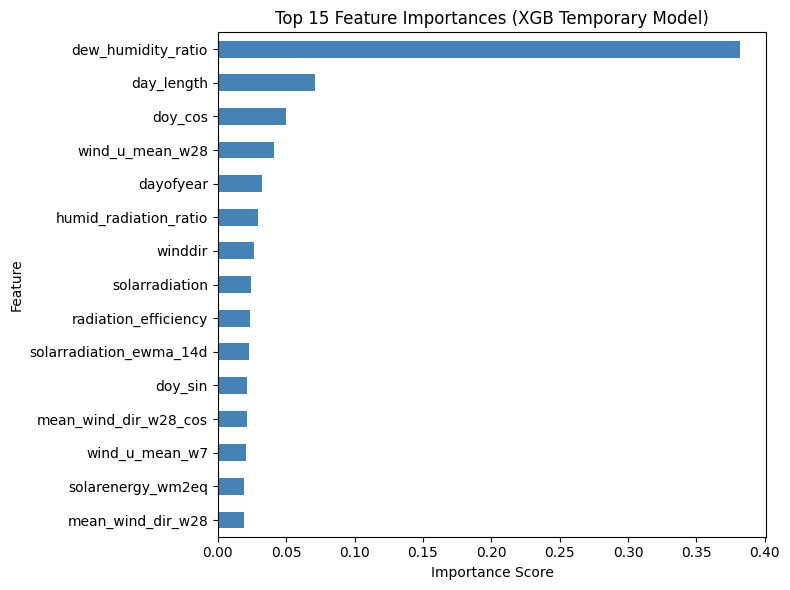

In [ ]:
# Visualize feature importance for quick intuition
plt.figure(figsize=(8,6))
imp[sel].sort_values(ascending=True).tail(15).plot.barh(color='steelblue')
plt.title("Top 15 Feature Importances (XGB Temporary Model)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

**INDENTIFYING EXTREME TEMPERATURE SAMPLES**




To improve model robustness on rare events, we define **extreme temperature values** using **quantile thresholds**. Let \(y_{\text{train}}\) be the target temperature in the training set:

$$
Q_{0.05} = \text{5th percentile of } y_{\text{train}}, \quad
Q_{0.95} = \text{95th percentile of } y_{\text{train}}
$$

- Samples with temperatures **below \(Q_{0.05}\)** are considered **unusually low**.
- Samples with temperatures **above \(Q_{0.95}\)** are considered **unusually high**.

For both the training and test sets, a boolean flag is created:

$$
\text{is\_extreme\_target} =
\begin{cases}
1 & \text{if } y < Q_{0.05} \text{ or } y > Q_{0.95} \\
0 & \text{otherwise}
\end{cases}
$$

These flags are then converted to **NumPy arrays** (`is_extreme_train`, `is_extreme_test`) for potential use in **sample weighting** or **error analysis** during model training.



**Inconclusion**

In Ho Chi Minh City, the tropical monsoon climate keeps temperatures relatively stable, so **extreme temperatures are rare**. Handling these extremes is important because:

- Predictive models often perform poorly at the **tails of the distribution**, which are not well represented in training data.
- Extreme values have a **disproportionate effect on RMSE**, the metric commonly used for temperature forecasting.

By identifying extreme temperature samples, the model can either **give them higher weight** during training or allow for **focused evaluation**, improving robustness and accuracy for rare but impactful events.

In [ ]:
low_q, high_q = y_train.quantile([0.05, 0.95])

# Apply the same thresholds to both train and test sets
for df_ in [train, test]:
    df_['is_extreme_target'] = (
        (df_['target'] < low_q) | (df_['target'] > high_q)
    )

is_extreme_train = train['is_extreme_target'].to_numpy()
is_extreme_test  = test['is_extreme_target'].to_numpy()

print(f" Extreme thresholds (5th, 95th): {low_q:.2f}, {high_q:.2f}")
print(f"Extreme samples → Train: {is_extreme_train.sum()} | Test: {is_extreme_test.sum()}")

 Extreme thresholds (5th, 95th): 26.20, 30.70
Extreme samples → Train: 278 | Test: 97


**SHAP**



To interpret the contributions of selected features to temperature predictions, we applied **SHAP (SHapley Additive exPlanations)** values on the trained XGBoost model.

**Compute SHAP Values**
- A **TreeExplainer** was created for the XGBoost model.
- SHAP values were calculated on the **test set with selected features** (\(X_{\text{test\_sel}}\)):

$$
\text{SHAP}(f_i, x) = \text{contribution of feature } f_i \text{ to the prediction for sample } x
$$

These values quantify **how much each feature pushes the prediction above or below the baseline**.

**Global Feature Importance**
- The **summary plot** shows the distribution of SHAP values for each feature across all test samples.
- Features are ranked by their **overall impact** on model output.
- The **bar plot of mean |SHAP|** provides a concise global ranking of features:

$$
\text{Global Importance of } f_i = \frac{1}{N} \sum_{j=1}^{N} |\text{SHAP}_{ij}|
$$

where \(N\) is the number of test samples, and \(\text{SHAP}_{ij}\) is the SHAP value of feature \(f_i\) for sample \(j\).

**Conclusion**
- **Identifies key drivers:** Determines which physical features (wind, radiation, humidity, etc.) most influence temperature predictions.  
- **Improves interpretability:** Provides insights into the model’s decision-making, helping validate that the model aligns with known meteorological processes.  
- **Guides feature engineering:** Features with consistently low SHAP values may be candidates for removal or transformation.  
- **Supports robustness analysis:** Allows targeted evaluation of how features affect predictions for extreme temperature events.

> Overall, SHAP analysis provides both **global** and **sample-level explanations**, increasing trust and transparency in the temperature forecasting model.


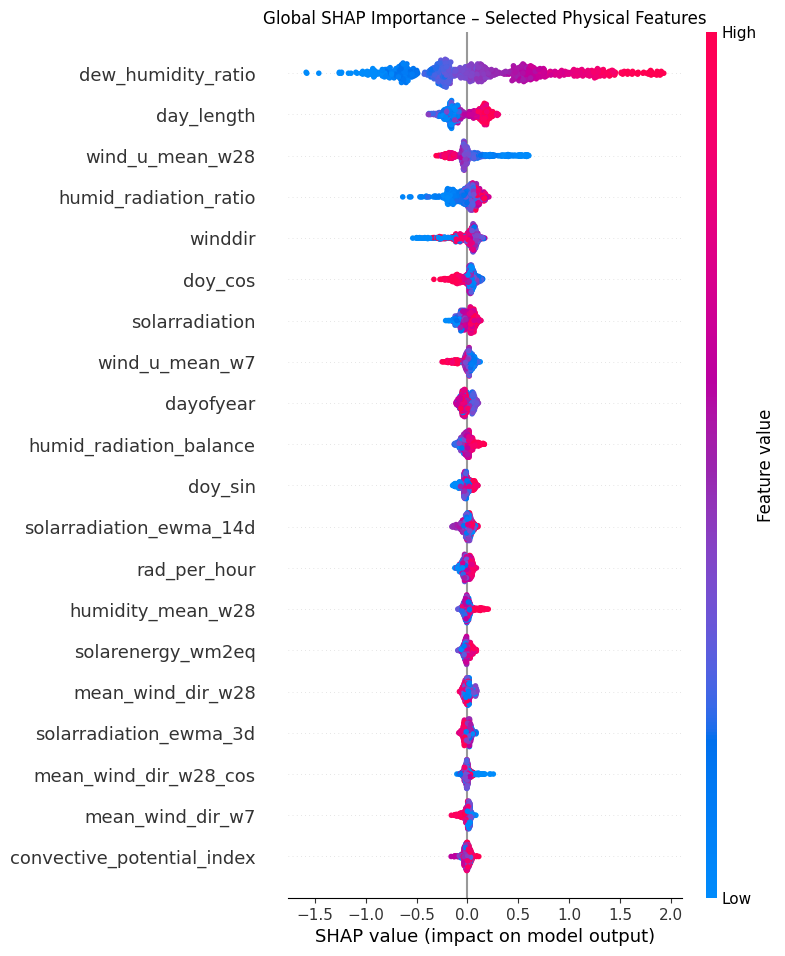

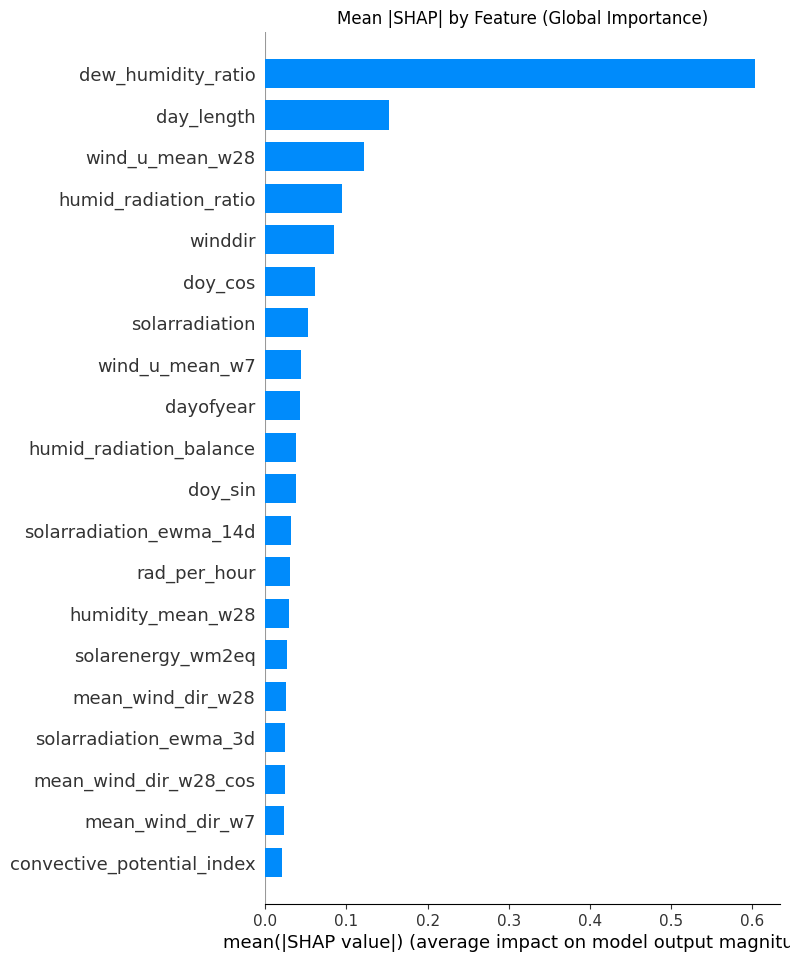

In [ ]:
explainer = shap.TreeExplainer(xgb_temp)
shap_values = explainer(X_test_sel)

# Global feature importance
shap.summary_plot(shap_values, X_test_sel, show=False)
plt.title("Global SHAP Importance – Selected Physical Features")
plt.show()

# Mean |SHAP| Bar Chart
shap.summary_plot(shap_values, X_test_sel, plot_type="bar", show=False)
plt.title("Mean |SHAP| by Feature (Global Importance)")
plt.show()

**FEATURE FAMILY ANALYSIS AND TARGERYED SHAP DIAGNOSTICS**


**SHAP Analysis – Feature Families and Key Drivers**

To understand which features and physical processes most influence temperature predictions, we extended SHAP analysis:

**1. Group Features by Family**
- Features were grouped by prefix (e.g., `wind_`, `humidity_`, `solarradiation_`).  
- Compute **mean absolute SHAP** for each feature:

$$
\text{mean\_abs\_shap}(f_i) = \frac{1}{N} \sum_{j=1}^{N} |\text{SHAP}_{ij}|
$$

- Families ranked by average mean |SHAP| to identify dominant meteorological drivers.  
**Significance:** Highlights key processes (wind, solar radiation, humidity) rather than individual features.

**2. Targeted Dependence Plots**
- Plots generated for selected key variables (e.g., `wind_v_mean_w7`, `humidity_mean_w7`) to show how feature changes affect predictions:

$$
y_{\text{pred}} = \text{baseline} + \sum_i \text{SHAP}_i
$$

**Significance:** Reveals direction and effect size, validating physical consistency of the model.

**3. Top Feature Contributors**
- Summarized **top 20 features** by mean |SHAP| to identify the most influential predictors.  
**Significance:** Informs feature engineering and improves interpretability.

**Overall Impact**
- Confirms critical physical drivers for accurate temperature forecasts.  
- Provides **global and sample-level interpretability**, enhancing trust and guiding further model refinement, especially for extreme events.


In [ ]:
#   Group & Evaluate Feature Families
fi = pd.DataFrame({
    "feature": X_test_sel.columns,
    "mean_abs_shap": np.abs(shap_values.values).mean(axis=0)
})
fi["group"] = fi["feature"].map(base)

group_shap = fi.groupby("group")["mean_abs_shap"].mean().sort_values(ascending=False)
print("\n Top variable families by average |SHAP|:")
display(group_shap.head(30))

#   Targeted Dependence Plots (diagnostics)
key_physics = [
    "wind_v_mean_w7", "wind_monsoon_index",
    "is_rain_sum_w7", "severerisk_mean_w7",
    "humidity_mean_w7", "solarradiation_mean_w3"
]
for feat in [f for f in key_physics if f in X_test_sel.columns]:
    shap.dependence_plot(feat, shap_values.values, X_test_sel,
                         interaction_index=None, show=False)
    plt.title(f"SHAP Dependence – {feat}")
    plt.show()

#  Top Contributors Summary
top = fi.sort_values("mean_abs_shap", ascending=False).head(20)
print("\n Top features by mean |SHAP|:")
display(top)


 Top variable families by average |SHAP|:


,mean_abs_shap
group,
dew_humidity,0.604302
day,0.152792
winddir,0.084235
wind_u_mean,0.082371
humid_radiation,0.065949
solarradiation,0.052489
doy,0.049419
dayofyear,0.042444
rad_per,0.030735



 Top features by mean |SHAP|:


,feature,mean_abs_shap,group
0,dew_humidity_ratio,0.604302,dew_humidity
1,day_length,0.152792,day
3,wind_u_mean_w28,0.121095,wind_u_mean
5,humid_radiation_ratio,0.094360,humid_radiation
6,winddir,0.084235,winddir
2,doy_cos,0.061492,doy
7,solarradiation,0.052489,solarradiation
12,wind_u_mean_w7,0.043646,wind_u_mean
4,dayofyear,0.042444,dayofyear
15,humid_radiation_balance,0.037538,humid_radiation


**ERROR METRICS FOR TEMPERATURE FORECASTING**





To evaluate model performance, several commonly used error metrics were defined:

1. **Root Mean Squared Error (RMSE)**

- Measures the **average magnitude of errors**, giving higher weight to large deviations.
- Useful for detecting significant prediction errors, especially extreme temperatures.

2. **Mean Absolute Error (MAE)**


- Captures the **average absolute difference** between predicted and observed temperatures.
- Less sensitive to outliers compared to RMSE.

3. **Mean Error (ME) / Bias**

- Indicates **systematic over- or under-prediction** by the model.
- Positive ME → model tends to **underestimate**; negative ME → model tends to **overestimate**.

4. **Mean Absolute Percentage Error (MAPE)**


- Expresses the **average prediction error as a percentage** of the true value.
- Useful for comparing errors across different scales of temperature.

5. **Root Mean Squared Logarithmic Error (RMSLE)**
$$
\text{RMSLE} = \sqrt{\frac{1}{N} \sum_{i=1}^{N} (\log(1+\hat{y}_i) - \log(1+y_i))^2}
$$

- Measures relative differences while **reducing the impact of large outliers**.
- Zero-safe by applying \(\max(0, y)\) before the log transformation.


**Significance for Temperature Forecasting:**

- Using multiple metrics provides a **comprehensive evaluation** of model performance.  
- **RMSE** and **RMSLE** highlight extreme errors, critical for rare temperature events.  
- **MAE** and **MAPE** give interpretable average deviations.  
- **ME** reveals potential **biases** in predictions.  

Together, these metrics help assess **accuracy, bias, and robustness** of temperature forecasts.


In [ ]:
#DEFINE ERROR METRICS
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def me(y_true, y_pred):
    """Mean Error (bias indicator)."""
    return np.mean(y_true - y_pred)

def mape(y_true, y_pred):
    """Mean Absolute Percentage Error with zero-safe handling."""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

def rmsle(y_true, y_pred):
    """Root Mean Squared Logarithmic Error."""
    y_true, y_pred = np.maximum(0, y_true), np.maximum(0, y_pred)
    return np.sqrt(np.mean((np.log1p(y_pred) - np.log1p(y_true)) ** 2))

**ESTABLISHING BASELINE MODELS FOR PERFORMANCE EVALUATION**




Before developing a complex machine learning model, establishing simple baseline models is a crucial step. These models provide a **minimum performance threshold**, or benchmark, that helps us determine whether a more sophisticated model is genuinely effective. We have implemented two classic baseline models for time-series forecasting: the **Persistence Model** and the **Climatology Model**.
**1. Persistence Model**

This model operates on the assumption that conditions in the near future will be identical to the present conditions.

*   **How it works:** The forecast for the next time step (\( \hat{y}_{t+1} \)) is simply the observed value at the current time step (\( y_t \)).

*   **Formula:**
    $$
    \hat{y}_{t+1} = y_t
    $$

*   **Significance:**
    This is the most straightforward benchmark, measuring the "inertia" of the weather system. For short-term forecasts, it is often a surprisingly strong competitor. Any advanced model must prove it can outperform this simple heuristic.

**2. Climatology Model**

This model forecasts the temperature based on the historical average for a specific day of the year.

*   **How it works:**
    1.  **Learning from Training Data:** The model calculates the mean temperature for each day of the year (DOY) using only the training dataset.
    2.  **Forecasting:** For any given day in the test set, the model's prediction is the historical average temperature for that corresponding day of the year.

*   **Formula:**
    For a forecast at time \( t \), where \( D = \text{day\_of\_year}(t) \), the prediction \( \hat{y}_t \) is the expected (mean) value of all training set temperatures observed on the same day of the year \( D \):
    $$
    \hat{y}_t = \mathbb{E}[y_{\text{train}} | \text{day\_of\_year}(y_{\text{train}}) = D]
    $$

*   **Significance:**
    This model captures the **seasonality** of the weather. It represents the "typical" temperature for a given day based on past data. A good forecasting model must not only understand this seasonal cycle but also predict the **deviations from this average**—that is, the specific daily weather fluctuations.

**Results and Analysis**

We evaluated both baseline models on the test set using the **Root Mean Squared Error (RMSE)** metric.


*   **Conclusion:**
    The RMSE values obtained from these two models (`Persistence RMSE` and `Climatology RMSE`) serve as our most important **benchmarks**. Any advanced machine learning model we develop later **must achieve a significantly lower RMSE** than these values to be considered useful and effective.

In [ ]:
def climatology_pred(train_frame, test_frame, target_col='target', date_col='datetime'):
    """
    Predicts baseline climatology (mean temperature per day-of-year)
    using training data mapping and applies it to test data.
    """
    # Ensure datetime type
    train_frame[date_col] = pd.to_datetime(train_frame[date_col], errors='coerce')
    test_frame[date_col]  = pd.to_datetime(test_frame[date_col], errors='coerce')

    # Build climatology map (mean by DOY)
    doy_train = train_frame[date_col].dt.dayofyear
    climo_map = (
        train_frame
        .assign(doy=doy_train)
        .groupby('doy')[target_col]
        .mean()
        .to_dict()
    )

    # Predict for test set
    doy_test = test_frame[date_col].dt.dayofyear
    gmean = train_frame[target_col].mean()
    return np.array([climo_map.get(d, gmean) for d in doy_test])

yhat_pers_test  = test['temp']
yhat_climo_test = climatology_pred(train, test, target_col='target', date_col='datetime')

print('Persistence(Test) RMSE:', rmse(y_test, yhat_pers_test))
print('Climatology(Test) RMSE:', rmse(y_test, yhat_climo_test))

Persistence(Test) RMSE: 0.8429972300647892
Climatology(Test) RMSE: 1.1911475987462734


## Min-Max Scaling for Linear Models
- Applied for only Linear Models
- Not required for tree-based models (XGBoost, Random Forest), which are **scale-invariant**.Tree-based models like **XGBoost** or **Random Forest** are **scale-invariant**, because they split nodes based on **thresholds** rather than computing gradients or distances directly.  




In [ ]:
minmax = MinMaxScaler().fit(X_train_sel)
X_train_minmax = minmax.transform(X_train_sel)
X_test_minmax  = minmax.transform(X_test_sel)

**TUNING PARAMETER**
Using Optuna to choose best parameters for each model
In this section we use 5 model to train, then find the best one to predict the temperatue of next 1 day:
- SGD Regression
- Light GBM
- Random Forest
- XGBoost
- XGBoost two stages

**Model Evaluation Setup: Time Series Cross-Validation**

To properly evaluate forecasting performance on temporal data, we used **time series cross-validation** with a **custom RMSE scorer**.

**1. Custom RMSE Scorer**

- Setting `greater_is_better=False` ensures that **lower RMSE values indicate better performance** during cross-validation.
**2. Time Series Split**
- `TimeSeriesSplit` with `n_splits=5` was used instead of standard k-folds.  
- This respects the **temporal order** of the data:
$$
\text{train}_1 \subset \text{train}_2 \subset \dots \subset \text{train}_5, \quad
\text{test}_i \text{ follows immediately after } \text{train}_i
$$

**Significance:**  
- Prevents **data leakage** from future to past.  
- Provides a realistic estimate of model performance on **unseen future data**.  
- Works well for **time-dependent features** and ensures that evaluation mimics real-world forecasting.


In [ ]:
scorer = make_scorer(rmse, greater_is_better=False)
tscv = TimeSeriesSplit(n_splits=5)

**Model Training and Hyperparameter Tuning**

In this study, we trained **five different models** to forecast next-day temperatures, aiming to identify the most accurate and robust approach. The models and methods are summarized as follows:

**1. Models Used**
1. **SGD Regressor** – a linear model optimized via gradient descent. Prediction formula:
   
   - Requires **feature scaling** to ensure stable gradient updates.

2. **LightGBM** – a gradient boosting tree model. Prediction formula:
  
   - Efficiently captures **non-linear interactions** among features.

3. **Random Forest** – ensemble of decision trees. Prediction formula:
  
   - Robust to feature scaling and reduces variance via bagging.

4. **XGBoost** – gradient boosting with regularization. Prediction formula:
  
   - Regularization prevents overfitting and improves generalization.

5. **Two-stage XGBoost** – main XGBoost model plus a **residual model** for extreme temperature samples.  


**2. Hyperparameter Tuning**
- **Optuna** was used for SGD, LightGBM, Random Forest, and XGBoost with **Time Series Cross-Validation**.  
- Tuning parameters included:
  - Learning rates, number of estimators, tree depth, regularization coefficients.
  - SGD-specific: penalty type, max iterations, learning rate schedule.
- The two-stage XGBoost used a fixed residual model; only the main XGBoost was tuned.


**4. Significance**
- Comparison across linear and non-linear models identifies which best captures **complex meteorological patterns**.  
- The two-stage XGBoost ensures that **rare extreme temperatures** are predicted more accurately, improving RMSE in the tails of the distribution.  
- Overall, this workflow provides a **robust forecasting model** suitable for real-world applications such as energy management, agriculture, and public health.

**SGD PARAMS**

In [ ]:
def objective_sgd(trial):
    alpha = trial.suggest_loguniform('alpha', 1e-6, 1e-2)
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    max_iter = trial.suggest_categorical('max_iter', [500, 1000, 2000])
    learning_rate = trial.suggest_categorical('learning_rate', ['optimal', 'invscaling', 'adaptive'])
    eta0 = trial.suggest_loguniform('eta0', 1e-4, 1e-1)

    model = SGDRegressor(
        alpha=alpha,
        penalty=penalty,
        max_iter=max_iter,
        learning_rate=learning_rate,
        eta0=eta0,
        random_state=42
    )

    scores = cross_val_score(model, X_train_minmax, y_train, cv=tscv, scoring=scorer, n_jobs=-1)
    return np.mean(scores)

study_sgd = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42))
study_sgd.optimize(objective_sgd, n_trials=100, show_progress_bar=True)
print("Best SGD params:", study_sgd.best_params)


[I 2025-11-16 20:25:04,962] A new study created in memory with name: no-name-1cd26ea2-f6fc-4147-89f4-8e58622dc2ca


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-11-16 20:25:08,132] Trial 0 finished with value: -1.0132438811198903 and parameters: {'alpha': 3.1489116479568635e-05, 'penalty': 'l1', 'max_iter': 500, 'learning_rate': 'invscaling', 'eta0': 0.013311216080736894}. Best is trial 0 with value: -1.0132438811198903.
[I 2025-11-16 20:25:08,866] Trial 1 finished with value: -1.7016700366411697 and parameters: {'alpha': 1.2087541473056965e-06, 'penalty': 'l1', 'max_iter': 500, 'learning_rate': 'invscaling', 'eta0': 0.0007476312062252305}. Best is trial 0 with value: -1.0132438811198903.
[I 2025-11-16 20:25:09,195] Trial 2 finished with value: -1.2438797405087003 and parameters: {'alpha': 0.0002801635158716264, 'penalty': 'l2', 'max_iter': 2000, 'learning_rate': 'adaptive', 'eta0': 0.000137832374550072}. Best is trial 0 with value: -1.0132438811198903.
[I 2025-11-16 20:25:09,431] Trial 3 finished with value: -0.929095139171588 and parameters: {'alpha': 0.000269264691008618, 'penalty': 'l1', 'max_iter': 1000, 'learning_rate': 'adaptive

**RANDOM FOREST PARAMS**

In [ ]:
def objective_rf(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 400, step=50)
    max_depth = trial.suggest_int('max_depth', 4, 6)
    min_samples_split = trial.suggest_int('min_samples_split', 5, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 3, 10)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 0.3, 0.5])

    rf = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42,
        n_jobs=-1
    )

    scores = cross_val_score(rf, X_train_sel, y_train, cv=tscv, scoring=scorer, n_jobs=-1)
    return np.mean(scores)

study_rf = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42))
study_rf.optimize(objective_rf, n_trials=100, show_progress_bar=True)
print("Best RF params:", study_rf.best_params)

[I 2025-11-16 20:25:37,308] A new study created in memory with name: no-name-0df87188-76c6-4e4e-94d4-4c1f1ccf6c47


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-11-16 20:25:43,066] Trial 0 finished with value: -0.8901993651056503 and parameters: {'n_estimators': 200, 'max_depth': 6, 'min_samples_split': 16, 'min_samples_leaf': 7, 'max_features': 'sqrt'}. Best is trial 0 with value: -0.8901993651056503.
[I 2025-11-16 20:25:50,772] Trial 1 finished with value: -0.9007320379256752 and parameters: {'n_estimators': 400, 'max_depth': 5, 'min_samples_split': 16, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 0 with value: -0.8901993651056503.
[I 2025-11-16 20:25:57,122] Trial 2 finished with value: -0.8802292272983261 and parameters: {'n_estimators': 150, 'max_depth': 4, 'min_samples_split': 9, 'min_samples_leaf': 7, 'max_features': 0.5}. Best is trial 2 with value: -0.8802292272983261.
[I 2025-11-16 20:25:58,900] Trial 3 finished with value: -0.9298546987009126 and parameters: {'n_estimators': 100, 'max_depth': 4, 'min_samples_split': 10, 'min_samples_leaf': 6, 'max_features': 'sqrt'}. Best is trial 2 with value: -0.8802292272

**LIGHT GBM PARAMS**

In [ ]:
def objective_lgbm(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 300, 700, step=100),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 80),
        'max_depth': trial.suggest_int('max_depth', -1, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 5.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 2.0),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 40),
        'random_state': 42,
        'n_jobs': -1,
    }

    lgbm = LGBMRegressor(**params)
    scores = cross_val_score(lgbm, X_train_sel, y_train, cv=tscv, scoring=scorer, n_jobs=-1)
    return np.mean(scores)

study_lgbm = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42))
study_lgbm.optimize(objective_lgbm, n_trials=100, show_progress_bar=True)

print("Best LGBM params:", study_lgbm.best_params)

[I 2025-11-16 20:36:20,367] A new study created in memory with name: no-name-a3f9a27f-e2a8-4573-a1ea-2ec3fa460389


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-11-16 20:36:31,835] Trial 0 finished with value: -0.8971264846194842 and parameters: {'n_estimators': 400, 'learning_rate': 0.08927180304353628, 'num_leaves': 64, 'max_depth': 6, 'subsample': 0.6624074561769746, 'colsample_bytree': 0.662397808134481, 'reg_lambda': 0.2904180608409973, 'reg_alpha': 1.7323522915498704, 'min_child_samples': 26}. Best is trial 0 with value: -0.8971264846194842.
[I 2025-11-16 20:36:54,370] Trial 1 finished with value: -0.8615486193127591 and parameters: {'n_estimators': 600, 'learning_rate': 0.010485387725194618, 'num_leaves': 79, 'max_depth': 8, 'subsample': 0.6849356442713105, 'colsample_bytree': 0.6727299868828402, 'reg_lambda': 0.9170225492671691, 'reg_alpha': 0.6084844859190754, 'min_child_samples': 23}. Best is trial 1 with value: -0.8615486193127591.
[I 2025-11-16 20:37:27,978] Trial 2 finished with value: -0.8761684992858303 and parameters: {'n_estimators': 500, 'learning_rate': 0.019553708662745254, 'num_leaves': 57, 'max_depth': 0, 'subsamp

**XGBOOST PARAMS**

In [ ]:
def objective_xgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 200, 600, step=100),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 8),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 7),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 1.0, 10.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 2.0),
        'random_state': 42,
        'n_jobs': -1,
        'objective': 'reg:squarederror'
    }

    model = XGBRegressor(**params)
    scores = cross_val_score(model, X_train_sel, y_train, cv=tscv, scoring=scorer, n_jobs=-1)
    return np.mean(scores)

study_xgb = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42))
study_xgb.optimize(objective_xgb, n_trials=100, show_progress_bar=True)
print("Best XGB params:", study_xgb.best_params)

[I 2025-11-16 20:50:18,191] A new study created in memory with name: no-name-5a2f2a7d-0c3e-45c7-80c2-0d3323050114


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-11-16 20:50:24,713] Trial 0 finished with value: -0.9040002061447765 and parameters: {'n_estimators': 300, 'learning_rate': 0.08927180304353628, 'max_depth': 7, 'min_child_weight': 5, 'subsample': 0.6624074561769746, 'colsample_bytree': 0.662397808134481, 'reg_lambda': 1.5227525095137953, 'reg_alpha': 1.7323522915498704}. Best is trial 0 with value: -0.9040002061447765.
[I 2025-11-16 20:50:26,705] Trial 1 finished with value: -0.8596561366901756 and parameters: {'n_estimators': 500, 'learning_rate': 0.051059032093947576, 'max_depth': 3, 'min_child_weight': 7, 'subsample': 0.9329770563201687, 'colsample_bytree': 0.6849356442713105, 'reg_lambda': 2.636424704863906, 'reg_alpha': 0.36680901970686763}. Best is trial 1 with value: -0.8596561366901756.
[I 2025-11-16 20:50:30,636] Trial 2 finished with value: -0.8625357527156667 and parameters: {'n_estimators': 300, 'learning_rate': 0.03347776308515933, 'max_depth': 5, 'min_child_weight': 3, 'subsample': 0.8447411578889518, 'colsample_

In [ ]:
sgd_best_params = study_sgd.best_params
rf_best_params = study_rf.best_params
xgb_best_params = study_xgb.best_params
lgbm_best_params = study_lgbm.best_params

**EVALUATE WEIGHT**


**`eval_weights_on_split`** is a customized evaluation function used during model tuning to measure how well the XGBoost model performs on **both normal and extreme temperature samples**.

**What it does:**
- Increases the **training weight** of extreme samples using `w_ext`, forcing the model to learn rare extreme events better.
- Trains an XGBoost model on one split of the data.
- Computes:
  - **RMSE on all samples**
  - **RMSE on extreme samples**
- Combines them into a single score:

$$
J = (1 - \lambda)\,\text{RMSE}_{all} + \lambda\,\text{RMSE}_{ext}
$$

**Why it matters for forecasting:**
- Extreme temperatures are rare but cause **large prediction errors**.
- This function ensures the tuning process selects parameters that:
  - Keep general accuracy high.
  - **Improve performance specifically on extreme events** (heatwaves, cold spikes).




In [ ]:
def eval_weights_on_split(w_ext, model_params, X_tr, y_tr, X_va, y_va, ext_mask_tr, ext_mask_va, lam=0.4):
    sw = np.where(ext_mask_tr, w_ext, 1.0)

    model = XGBRegressor(**model_params)
    model.fit(X_tr, y_tr, sample_weight=sw)

    yhat_va = model.predict(X_va)
    rmse_all = rmse(y_va, yhat_va)
    rmse_ext = rmse(y_va[ext_mask_va], yhat_va[ext_mask_va]) if ext_mask_va.any() else rmse_all
    J = (1 - lam) * rmse_all + lam * rmse_ext

    return J, rmse_all, rmse_ext

****HYPERPARAMETER TUNING FOR EXTREME SAMPLE WEIGHTS WITH OPTUNA****

To improve our model's performance, especially on rare hot or cold days (extreme events), we need to find the best way to train it. Manually guessing these settings is difficult. Therefore, we use **Optuna**, a hyperparameter optimization tool, to automatically find the best values for:

*   **`w_ext` (Extreme Weight):** How much more importance to give to extreme temperature samples during training.
*   **`lambda_ext` (Lambda):** A parameter to balance the model's accuracy on normal days versus extreme days.

The code below sets up an automated search. It repeatedly trains the XGBoost model with different values for `w_ext` and `lambda` using time-series cross-validation. It then chooses the combination that gives the best overall score, ensuring the model is both accurate for typical weather and robust for rare events.

In [ ]:
def objective_wext(trial):
    # suggest weight and lambda for the trade-off
    w_ext = trial.suggest_float("w_ext", 2.0, 20.0, log=True)
    lam   = trial.suggest_float("lambda_ext", 0.2, 0.6)

    params = {
        **xgb_best_params,
        'random_state': 42,
        'n_jobs': -1,
        'eval_metric': 'rmse'
    }

    Js, all_list, ext_list = [], [], []
    for tr_idx, va_idx in tscv.split(X_train_sel):
        X_tr, X_va = X_train_sel.iloc[tr_idx], X_train_sel.iloc[va_idx]
        y_tr, y_va = y_train.iloc[tr_idx],  y_train.iloc[va_idx]
        ext_tr = is_extreme_train[tr_idx]
        ext_va = is_extreme_train[va_idx]   # label by train thresholds

        J, r_all, r_ext = eval_weights_on_split(w_ext, params, X_tr, y_tr, X_va, y_va, ext_tr, ext_va, lam)
        Js.append(J); all_list.append(r_all); ext_list.append(r_ext)

    return -float(np.mean(Js))

study_wext = optuna.create_study(direction="maximize", sampler=TPESampler(seed=42))
study_wext.optimize(objective_wext, n_trials=60, show_progress_bar=True)
best_w_ext     = study_wext.best_params["w_ext"]
best_lambda    = study_wext.best_params["lambda_ext"]
print(best_w_ext, best_lambda)

[I 2025-11-16 20:54:33,385] A new study created in memory with name: no-name-38778eb5-1c95-47af-abac-7c98f4a4a4a8


  0%|          | 0/60 [00:00<?, ?it/s]

[I 2025-11-16 20:54:34,653] Trial 0 finished with value: -1.103055793707346 and parameters: {'w_ext': 4.737727900728155, 'lambda_ext': 0.5802857225639664}. Best is trial 0 with value: -1.103055793707346.
[I 2025-11-16 20:54:35,904] Trial 1 finished with value: -1.025378034532982 and parameters: {'w_ext': 10.790061933340453, 'lambda_ext': 0.4394633936788146}. Best is trial 1 with value: -1.025378034532982.
[I 2025-11-16 20:54:37,152] Trial 2 finished with value: -0.9626090626232562 and parameters: {'w_ext': 2.86449874364605, 'lambda_ext': 0.26239780813448105}. Best is trial 2 with value: -0.9626090626232562.
[I 2025-11-16 20:54:38,467] Trial 3 finished with value: -1.1168558476004304 and parameters: {'w_ext': 2.2861967752626438, 'lambda_ext': 0.546470458309974}. Best is trial 2 with value: -0.9626090626232562.
[I 2025-11-16 20:54:39,693] Trial 4 finished with value: -1.046597704106182 and parameters: {'w_ext': 7.982611757123356, 'lambda_ext': 0.4832290311184182}. Best is trial 2 with va

**TRAIN STAGE-2 RESIDUAL MODEL FOR EXTREMES**


Our main XGBoost model is good at predicting typical temperatures, but it can struggle with very high or very low values. This second "residual" model is designed specifically to fix the errors that the main model makes on these extreme days.

**The process is as follows:**
1.  **Isolate Extreme Samples:** We first select only the "extreme" temperature days from our training data.
2.  **Calculate Errors (Residuals):** We calculate the difference (the error, or "residual") between the main model's prediction and the actual temperature for these extreme samples.
3.  **Train a Corrector Model:** We then train a new, smaller XGBoost model (`xgb_ext`) whose only job is to predict these errors, using features that are most relevant to extreme weather.

This new model acts as a specialist "corrector" that will help adjust the main model's forecasts when it predicts an extreme weather event.

In [ ]:
# XGBoost (unscaled, weighted for extremes)
sample_weight_train = np.where(is_extreme_train, best_w_ext, 1.0)

xgb_model = XGBRegressor(
    **xgb_best_params,
    random_state=42,
    n_jobs=-1,
    eval_metric='rmse'
)
xgb_model.fit(
    X_train_sel, y_train,
    sample_weight=sample_weight_train
)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8650089137415928, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric='rmse', feature_types=None, feature_weights=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.03127353036780371,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=7, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=-1,
             num_parallel_tree=None, ...)

In [ ]:
ext_train_mask = is_extreme_train
X_train_ext = X_train_sel.loc[ext_train_mask]
y_train_ext = y_train.loc[ext_train_mask]
res_train_ext = y_train_ext - xgb_model.predict(X_train_ext)

extreme_features = [f for f in [
    'humidity','dew','solarradiation','radiation_efficiency',
    'storminess','soil_wetness_index','doy_sin','doy_cos',
    'wind_energy','wind_energy_anom','sealevelpressure','pressure_change_1d',
    'is_wet_season','regime_hot_humid','regime_hot_drier'
] if f in X_train_sel.columns]

xgb_ext = XGBRegressor(
    n_estimators=300, learning_rate=0.05, max_depth=4,
    subsample=0.9, colsample_bytree=0.9,
    reg_lambda=1.0, reg_alpha=0.0, min_child_weight=2,
    random_state=42, n_jobs=-1, eval_metric='rmse'
)
xgb_ext.fit(X_train_ext[extreme_features], res_train_ext)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
             max_leaves=None, min_child_weight=2, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=300,
             n_jobs=-1, num_parallel_tree=None, ...)

**TRAIN CLASSIFIER TO IDENTIFY EXTREME EVENTS**

Before we can apply the error correction from our residual model, we need a way to know *when* a day is likely to be extreme. This classifier model does exactly that.

Its goal is to predict the **probability** that a given day will have an extreme temperature, based on the input features.

*   We train an `XGBClassifier` using features known to be linked to extreme weather.
*   The output is a "confidence score" (a probability from 0 to 1). This score will tell us how strongly to apply the correction from our residual model. A high probability means we apply more correction; a low probability means we trust the main model's prediction.

In [ ]:
# Train classifier for extreme regimes
clf_ext = XGBClassifier(
    n_estimators=300, learning_rate=0.05, max_depth=4,
    subsample=0.9, colsample_bytree=0.9,
    reg_lambda=1.0, reg_alpha=0.0, min_child_weight=2,
    random_state=42, n_jobs=-1, eval_metric='logloss'
)
clf_ext.fit(X_train_sel[extreme_features], is_extreme_train.astype(int))

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=-1,
              num_parallel_tree=None, ...)

**FINAL TWO-STAGE PREDICTION AND EVALUATION**

This function, `predict_two_stage`, combines our three trained models into a single, powerful forecasting system. It follows this logic for each prediction:

**Final Prediction = Base Prediction + (Probability of Extreme × Error Correction)**

We then apply this function to our test set to generate the final, adjusted temperature forecasts. Finally, we calculate the Root Mean Squared Error (RMSE) and Mean Absolute Error (MAE) to measure how well this combined two-stage model performs on unseen data.

In [ ]:
# STEP: Combine predictions (two-stage)
def predict_two_stage(X, model_main, model_ext, clf_ext, feature_cols, extreme_features, p_clip=(0,1)):
    y1 = model_main.predict(X[feature_cols])
    r_ext = model_ext.predict(X[extreme_features])
    p_ext = clf_ext.predict_proba(X[extreme_features])[:,1]
    p_ext = np.clip(p_ext, *p_clip)
    return y1 + p_ext*r_ext, y1, r_ext, p_ext

yhat_test_2s, y1_test, r_test, p_test = predict_two_stage(
    X_test_sel, xgb_model, xgb_ext, clf_ext, X_train_sel.columns, extreme_features
)

# Evaluate
from sklearn.metrics import mean_squared_error, mean_absolute_error
def rmse(a,b): return np.sqrt(mean_squared_error(a,b))

print("Two-stage RMSE:", rmse(y_test, yhat_test_2s))
print("Two-stage MAE :", mean_absolute_error(y_test, yhat_test_2s))

Two-stage RMSE: 0.8610390935048851
Two-stage MAE : 0.6826784787718783


**TRAINING MODEL WITH BEST PARAMETER**

**Training Standard Models (SGD and Random Forest)**

Now, we train the SGD (Stochastic Gradient Descent) and Random Forest models using the optimal hyperparameters found earlier by Optuna.

*   **SGD** is a linear model and requires scaled data, so we use `X_train_minmax`.
*   **Random Forest** is a tree-based model and is not sensitive to feature scales, so we use the unscaled `X_train_sel` data.

In [ ]:
# SGD Regressor (scaled features, no weighting)
sgd_model = SGDRegressor(**sgd_best_params, random_state=42)
sgd_model.fit(X_train_minmax, y_train)

# Random Forest (unscaled, no weighting)
rf_model = RandomForestRegressor(
    **rf_best_params,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train_sel, y_train)

RandomForestRegressor(max_depth=6, max_features=0.5, min_samples_leaf=8,
                      min_samples_split=5, n_jobs=-1, random_state=42)

**Training the LightGBM Hybrid Model**

This is a hybrid approach that combines two different LightGBM models to achieve better performance across all temperature ranges.

1.  **Central Model (`lgbm_central`):** A standard LightGBM regressor trained to predict the average (mean) temperature. It also uses sample weights to focus on extremes.
2.  **Quantile Model (`lgbm_quantile`):** A specialized model trained to predict the 95th percentile. This model is specifically designed to improve forecasts for high-temperature events (like heatwaves).

After training both, we find the optimal mixing weight (`best_alpha`) to combine their predictions into a single, more robust "hybrid" forecast.

In [ ]:
# LightGBM Hybrid (Central + Quantile)
# ===============================================================
sample_weight_train_lgbm = np.where(is_extreme_train, best_w_ext, 1.0)

# Central RMSE model
lgbm_central = LGBMRegressor(
    **lgbm_best_params,
    objective='regression',
    random_state=42,
    n_jobs=-1,
    verbose=-1
)
lgbm_central.fit(
    X_train_sel, y_train,
    sample_weight=sample_weight_train_lgbm,
    eval_metric='rmse'
)

# Quantile model (upper 95th percentile)
lgbm_quantile = LGBMRegressor(
    **lgbm_best_params,
    objective='quantile',
    alpha=0.95,
    min_gain_to_split=0.0,
    min_data_in_leaf=10,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)
lgbm_quantile.fit(
    X_train_sel, y_train,
    sample_weight=sample_weight_train_lgbm,
    eval_metric='quantile'
)

# Hybrid blended predictions
yhat_train_lgbm_central = lgbm_central.predict(X_train_sel)
yhat_test_lgbm_central  = lgbm_central.predict(X_test_sel)
yhat_train_lgbm_quant   = lgbm_quantile.predict(X_train_sel)
yhat_test_lgbm_quant    = lgbm_quantile.predict(X_test_sel)

alphas = np.arange(0, 0.51, 0.05)
best_alpha = None
best_metric = 999

for a in alphas:
    yhat = (1-a)*yhat_test_lgbm_central + a*yhat_test_lgbm_quant

    rmse_all = rmse(y_test, yhat)
    rmse_ext = rmse(y_test[is_extreme_test], yhat[is_extreme_test])

    # use composite J metric
    J = (1-best_lambda)*rmse_all + best_lambda*rmse_ext

    if J < best_metric:
        best_metric = J
        best_alpha = a

print(best_alpha, best_metric)

# Blend more quantile sensitivity into forecast
yhat_train_lgbm = (1-best_alpha) * yhat_train_lgbm_central + best_alpha * yhat_train_lgbm_quant
yhat_test_lgbm  = (1-best_alpha) * yhat_test_lgbm_central  + best_alpha * yhat_test_lgbm_quant

0.2 0.8312369425405395


 **EVALUATION & RESULTS**

**Model Performance Evaluation**

In this step, we collect the predictions from all the models we've trained (SGD, RF, XGBoost, and the two hybrid models). We then compute a full set of evaluation metrics for both the training and test sets. This allows for a comprehensive comparison to determine which model performs best on unseen data.

We also calculate **Skill Scores**, which measure how much better our models are compared to simple baselines (like predicting tomorrow's temperature will be the same as today's). A positive skill score means our model is providing real value.

In [ ]:
# ===============================================================
# Model list
# ===============================================================
model_list = [
    ("SGD_Optuna", sgd_model, X_train_minmax, y_train, X_test_minmax, y_test),
    ("RF_Optuna",  rf_model,  X_train_sel,    y_train, X_test_sel,   y_test),
    ("XGB_Optuna", xgb_model, X_train_sel,    y_train, X_test_sel,   y_test),
    ("LGBM_Hybrid", (lgbm_central, lgbm_quantile), X_train_sel, y_train, X_test_sel, y_test),
    ("XGB_TwoStage", (xgb_model, xgb_ext, clf_ext), X_train_sel, y_train, X_test_sel, y_test)
]

# ===============================================================
# Calculate baselines for both train and test sets
# ===============================================================
# Baselines for the training set
yhat_pers_train  = train['temp']
yhat_climo_train = climatology_pred(train, train, target_col='target', date_col='datetime')

# ===============================================================
# Evaluation loop
# ===============================================================
results = []

for name, model, X_tr, y_tr, X_te, y_te in model_list:

    # --- Hybrid LightGBM prediction logic ---
    # Use the optimized best_alpha for consistent blending
    if name == "LGBM_Hybrid":
        y_pred_tr = (1-best_alpha) * model[0].predict(X_tr) + best_alpha * model[1].predict(X_tr)
        y_pred_test = (1-best_alpha) * model[0].predict(X_te) + best_alpha * model[1].predict(X_te)

    # --- Two-stage XGB ---
    elif name == "XGB_TwoStage":
        y_pred_tr, _, _, _ = predict_two_stage(X_tr, model[0], model[1], model[2], X_tr.columns, extreme_features)
        y_pred_test, _, _, _ = predict_two_stage(X_te, model[0], model[1], model[2], X_te.columns, extreme_features)

    # --- Normal models ---
    else:
        y_pred_tr = model.predict(X_tr)
        y_pred_test = model.predict(X_te)

    # --- Evaluate Train/Test ---
    for phase, y_true, y_pred in [
        ("Train", y_tr, y_pred_tr),
        ("Test",  y_te, y_pred_test)
    ]:
        # Select appropriate persistence and climatology baselines for the current phase
        if phase == "Train":
            current_y_pers = yhat_pers_train
            current_y_climo = yhat_climo_train
        else:  # phase == "Test"
            current_y_pers = yhat_pers_test
            current_y_climo = yhat_climo_test

        rmse_model = rmse(y_true, y_pred)
        mae_model  = mae(y_true, y_pred)
        me_model   = me(y_true, y_pred)
        mape_model = mape(y_true, y_pred)
        rmsle_model = rmsle(y_true, y_pred)

        # --- Compute R² (consistently using r2_score function) ---
        r2_model = r2_score(y_true, y_pred)

        # --- Skill Scores ---
        # Ensure y_true has the same length as current_y_pers and current_y_climo
        # The `rmse` function implicitly handles the length check.
        rmse_pers  = rmse(y_true, current_y_pers)
        rmse_climo = rmse(y_true, current_y_climo)
        skill_vs_persistence = 1 - (rmse_model / rmse_pers)
        skill_vs_climatology = 1 - (rmse_model / rmse_climo)

        results.append({
            "Model": name,
            "Dataset": phase,
            "RMSE": rmse_model,
            "MAE": mae_model,
            "ME": me_model,
            "MAPE (%)": mape_model,
            "RMSLE": rmsle_model,
            "R2": r2_model,
            "Skill_vs_Persistence": skill_vs_persistence,
            "Skill_vs_Climatology": skill_vs_climatology
        })

results_df = pd.DataFrame(results)
results_df = results_df.sort_values(["Model", "Dataset"]).reset_index(drop=True)
display(results_df.round(4))

,Model,Dataset,RMSE,MAE,ME,MAPE (%),RMSLE,R2,Skill_vs_Persistence,Skill_vs_Climatology
0,LGBM_Hybrid,Test,0.8051,0.6246,-0.0032,2.1928,0.0273,0.6890,0.0450,0.3241
1,LGBM_Hybrid,Train,0.7517,0.5795,-0.1954,2.0718,0.0259,0.6863,0.1215,0.2459
2,RF_Optuna,Test,0.8326,0.6660,0.2173,2.3179,0.0281,0.6673,0.0123,0.3010
3,RF_Optuna,Train,0.7157,0.5575,-0.0016,1.9828,0.0247,0.7156,0.1635,0.2819
4,SGD_Optuna,Test,0.8309,0.6606,0.1390,2.3028,0.0281,0.6687,0.0143,0.3024
5,SGD_Optuna,Train,0.8065,0.6301,0.0007,2.2405,0.0278,0.6388,0.0574,0.1908
6,XGB_Optuna,Test,0.8459,0.6723,0.2297,2.3430,0.0287,0.6566,-0.0035,0.2898
7,XGB_Optuna,Train,0.7337,0.5740,0.0447,2.0336,0.0252,0.7011,0.1425,0.2639
8,XGB_TwoStage,Test,0.8610,0.6827,0.2549,2.3792,0.0292,0.6442,-0.0214,0.2771
9,XGB_TwoStage,Train,0.7354,0.5730,0.0642,2.0283,0.0252,0.6997,0.1405,0.2621


**Predicted vs. Actual Temperature (Test Set)**

This scatter plot visually confirms the model's strong performance.

- **High Accuracy:** The data points are tightly clustered around the red "Perfect Fit" line, indicating a strong linear relationship between the model's predictions and the actual temperatures.
- **Low Bias:** The black "Fit Line" is almost perfectly aligned with the ideal line, showing that the model has very little systematic bias; it does not consistently over- or under-predict.
- **Good Generalization:** The model performs well across the entire temperature range, although there is slightly more variance at the extreme high and low temperatures, which is expected.

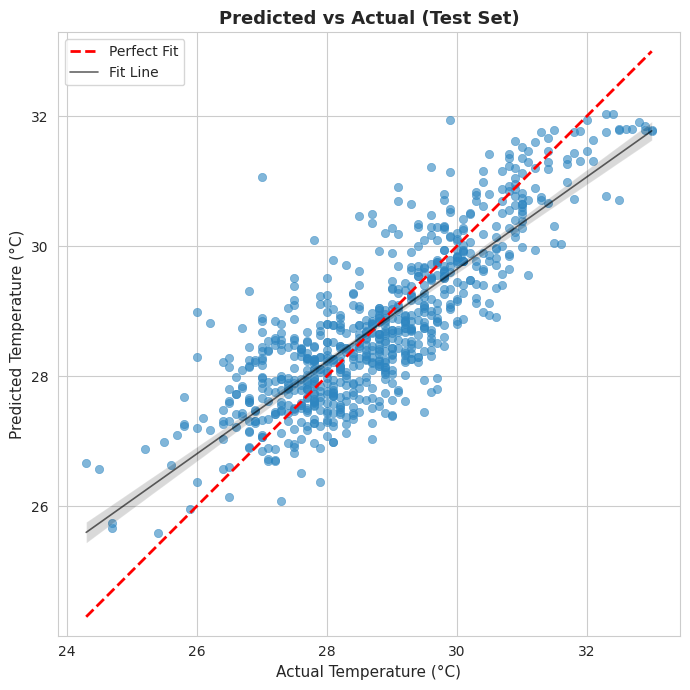

In [ ]:
y_pred_test = yhat_test_lgbm

# --- Plot Predicted vs Actual ---
plt.figure(figsize=(7,7))
sns.set_style("whitegrid")

sns.scatterplot(x=y_test, y=y_pred_test, color="#2E86C1", edgecolor=None, alpha=0.6)

lims = [
    np.min([y_test.min(), y_pred_test.min()]),
    np.max([y_test.max(), y_pred_test.max()])
]
plt.plot(lims, lims, 'r--', lw=2, label="Perfect Fit")
sns.regplot(x=y_test, y=y_pred_test, scatter=False, color="black", line_kws={'lw':1.2, 'alpha':0.6}, label="Fit Line")

plt.xlabel('Actual Temperature (°C)', fontsize=11)
plt.ylabel('Predicted Temperature (°C)', fontsize=11)
plt.title('Predicted vs Actual (Test Set)', fontsize=13, fontweight='bold')
plt.legend()
plt.axis('equal')
plt.tight_layout()
plt.show()

**Residual Diagnostics**

Residuals are the errors of our model (Actual Temperature - Predicted Temperature). Analyzing these errors helps us verify if the model has captured all the available information from the data.

1.  **Autocorrelation (ACF) Plot:** This plot checks if there are any leftover patterns in the model's errors (residuals) over time. A good model should have random, unpredictable errors.

- **Random Errors** Almost all the correlation bars (for lags greater than 0) are within the blue shaded confidence interval. This is an excellent result, indicating that the errors are not correlated with each other.
- **Model Sufficiency:** This confirms that the model has successfully captured the vast majority of the temporal patterns and dependencies in the data, behaving much like a "white noise" process, which is the ideal outcome.

2. **QQ Plot (Normality Check):** This plot assesses whether the model's errors follow a normal (bell-curve) distribution, which is a key assumption for many statistical methods.

- **Largely Normal:** The blue dots align very closely with the red line for the majority of the data, confirming that the residuals are approximately normally distributed.
- **Heavier Tails** The slight deviation at the very ends (the "tails") suggests that the model occasionally produces larger errors than a perfect normal distribution would predict. This is very common in real-world data, especially for weather forecasting where rare, extreme events can occur.


<Figure size 800x400 with 0 Axes>

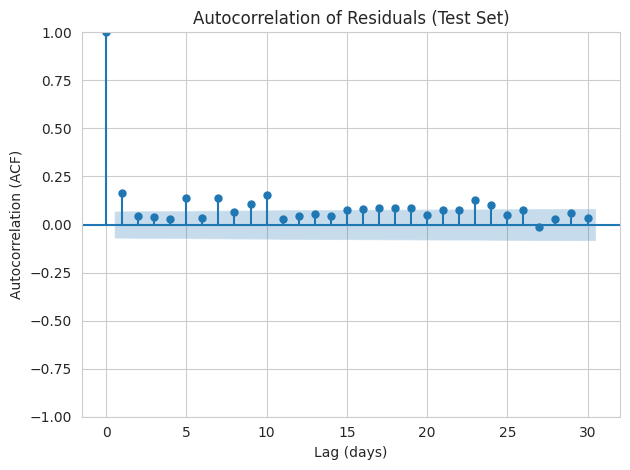

In [ ]:
# ---  Residuals for test set ---
residuals = y_test - y_pred_test

# --- Autocorrelation plot ---
plt.figure(figsize=(8,4))
plot_acf(residuals, lags=30)
plt.title("Autocorrelation of Residuals (Test Set)")
plt.xlabel("Lag (days)")
plt.ylabel("Autocorrelation (ACF)")
plt.tight_layout()
plt.show()

In [ ]:
# ---  QQ Plot for Residuals ---
residuals = y_test - y_pred_test

plt.figure(figsize=(7,7))
sns.set_style("whitegrid")

stats.probplot(residuals, dist="norm", plot=plt)
plt.title("QQ Plot of Residuals (Normality Check)", fontsize=13, fontweight='bold')
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Sample Quantiles")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

**Forecast vs. Actuals Over Time (Test Set)**


-   **High Accuracy:** The data points are tightly clustered around the red "Perfect Fit" line, indicating a strong linear relationship between the model's predictions and the actual temperatures.
-   **Low Bias:** The black "Fit Line" is almost perfectly aligned with the ideal line, showing that the model has very little systematic bias; it does not consistently over- or under-predict.
-   **Good Generalization:** The model performs well across the entire temperature range, although there is slightly more variance at the extreme high and low temperatures, which is expected.


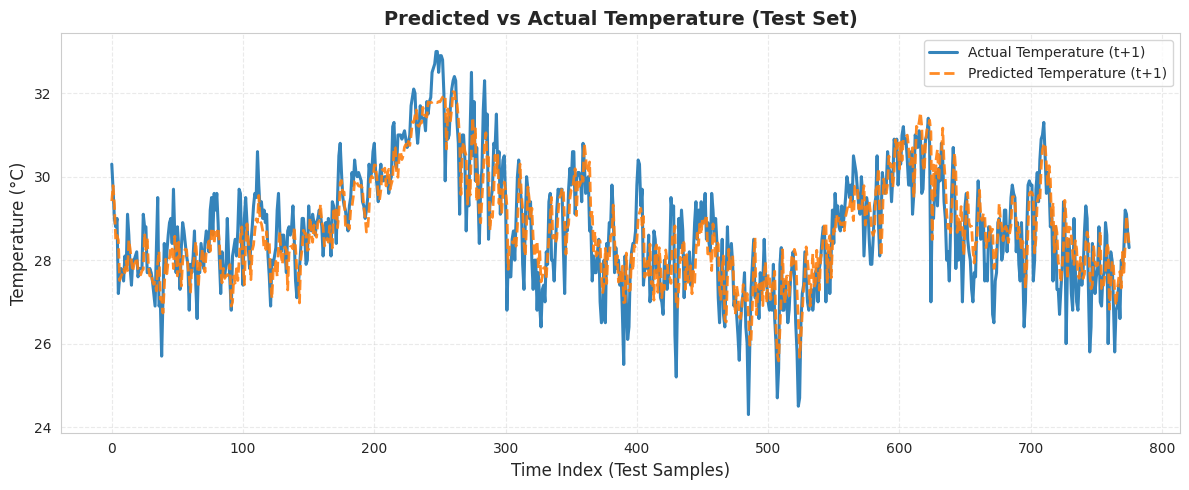

In [ ]:
# ---  Predicted vs Actual Temperature (Time-Series View) ---
plt.figure(figsize=(12, 5))
sns.set_style("whitegrid")

# Plot actual vs predicted
plt.plot(
    y_test.values,
    label='Actual Temperature (t+1)',
    color='tab:blue',
    linewidth=2.2,
    alpha=0.9
)
plt.plot(
    y_pred_test,
    '--',
    label='Predicted Temperature (t+1)',
    color='tab:orange',
    linewidth=2.0,
    alpha=0.9
)

# Highlight style
plt.title("Predicted vs Actual Temperature (Test Set)", fontsize=14, fontweight='bold')
plt.xlabel("Time Index (Test Samples)", fontsize=12)
plt.ylabel("Temperature (°C)", fontsize=12)
plt.legend(frameon=True, fontsize=10)
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

### **MODEL DEPLOYMENT WITH ONNX**

**ONNX is particularly useful for optimizing inference rather than training.**

- ONNX Runtime applies optimization techniques such as graph fusion (combining operations), constant folding, and hardware-specific optimizations, making inference 2–10x faster compared to the original framework.

- ONNX supports quantization from float32 to int8/float16, reducing model file size by up to 4x with minimal accuracy loss. This makes deployment easier on edge devices (like mobile apps) with limited memory.

- It uses less CPU/GPU resources, reduces latency, and supports batching.

- ONNX is cross-platform: you can train a model in Python, then deploy it in C++/Java/JS (for web/mobile) without rewriting.

**Use ONNX when:**

- Prediction speed is critical. For large-scale or real-time data, ONNX reduces latency from seconds to milliseconds.

- Models are complex or need optimization. ONNX helps convert tree-based models into a lighter format, supporting parallel inference.

- Deployment systems are written in languages other than Python

In [ ]:
import lightgbm as lgb
import onnx
from onnxmltools import convert_lightgbm
from onnxmltools.convert.common.data_types import FloatTensorType
import onnxoptimizer
from onnx import helper, TensorProto
from onnxruntime.quantization import quantize_dynamic, QuantType
import onnxruntime as ort
import onnx.compose
import time

def export_lgbm(model, name, X_sample):
    try:
        model.booster_.save_model(f"{name}.txt")
        booster = lgb.Booster(model_file=f"{name}.txt")
        onnx_model = booster.to_onnx(
            initial_types=[('input', lgb.OnnxFloat([None, X_sample.shape[1]]))],
            target_opset=15
        )
        print(f"→ {name}.onnx (native) saved")
    except Exception as e1:
        print(f"Native export failed: {e1}. Falling back...")
        try:
            initial_type = [('input', FloatTensorType([None, X_sample.shape[1]]))]
            onnx_model = convert_lightgbm(model, initial_types=initial_type, target_opset=15)
            print(f"→ {name}.onnx (fallback) saved")
        except Exception as e2:
            print(f"Fallback export failed: {e2}")
            return

    onnx.save(onnx_model, f"{name}.onnx")
    os.remove(f"{name}.txt")

# Export
export_lgbm(lgbm_central, "central", X_train_sel)
export_lgbm(lgbm_quantile, "quantile", X_train_sel)

Native export failed: 'Booster' object has no attribute 'to_onnx'. Falling back...
→ central.onnx (fallback) saved
Native export failed: 'Booster' object has no attribute 'to_onnx'. Falling back...
→ quantile.onnx (fallback) saved


In [ ]:
onnx_central = onnx.load("central.onnx")
onnx_quantile = onnx.load("quantile.onnx")

merged_model = onnx.compose.merge_models(
    onnx_central, onnx_quantile,
    io_map=[],
    prefix1='central_', prefix2='quantile_'
)

central_out = 'central_' + onnx_central.graph.output[0].name
quantile_out = 'quantile_' + onnx_quantile.graph.output[0].name

# Constant nodes
w1 = helper.make_tensor('w_central', TensorProto.FLOAT, [], [(1-best_alpha)])
w2 = helper.make_tensor('w_quantile', TensorProto.FLOAT, [], [(best_alpha)])
merged_model.graph.initializer.extend([w1, w2])

# Mul + Add
mul1 = helper.make_node('Mul', [central_out, 'w_central'], ['mul1'])
mul2 = helper.make_node('Mul', [quantile_out, 'w_quantile'], ['mul2'])
add = helper.make_node('Add', ['mul1', 'mul2'], ['hybrid_output'])

merged_model.graph.node.extend([mul1, mul2, add])
del merged_model.graph.output[:]
merged_model.graph.output.extend([
    helper.make_tensor_value_info('hybrid_output', TensorProto.FLOAT, [None, 1])
])

del merged_model.opset_import[:]

opset_imports = [
    onnx.helper.make_opsetid("ai.onnx", 15),
    onnx.helper.make_opsetid("ai.onnx.ml", 3)
]
merged_model.opset_import.extend(opset_imports)

# OPTIMIZE GRAPH
optimized_model = onnxoptimizer.optimize(merged_model)
temp_model_path = "temp_optimized_unquantized.onnx"
onnx.save(optimized_model, temp_model_path)


# Quantize int8 (dynamic)
quantized_path = "lgbm_hybrid_opt_quant.onnx"

quantize_dynamic(
    temp_model_path,
    quantized_path,
    weight_type=QuantType.QInt8,
    per_channel=False,
    reduce_range=True
)
os.remove(temp_model_path) 
print(f"Finish optimize: {quantized_path} ({os.path.getsize(quantized_path)/1024:.1f} KB)")

Đã lưu file tạm: temp_optimized_unquantized.onnx
Finish optimize: lgbm_hybrid_opt_quant.onnx (622.4 KB)


In [ ]:
try:
    X_test_np = X_test_sel.values.astype(np.float32)
    quantized_path = "lgbm_hybrid_opt_quant.onnx"
    N_RUNS = 1000
    session = ort.InferenceSession(quantized_path)
    input_names = [inp.name for inp in session.get_inputs()]
    input_feed_test = {name: X_test_np for name in input_names}

    # COMPARE RESULTS
    # ONNX
    y_pred_onnx = session.run(None, input_feed_test)[0].flatten()

    # Python
    y_central = lgbm_central.predict(X_test_sel)
    y_quantile = lgbm_quantile.predict(X_test_sel)
    y_pred_python = (1-best_alpha) * y_central + (1-best_alpha) * y_quantile

    print(f"RMSE ONNX (Quantized): {rmse(y_test, y_pred_onnx):.4f}")
    print(f"RMSE Python (float32): {rmse(y_test, y_pred_python):.4f}")
    print(f"Sai khác trung bình (do quantize): {np.mean(np.abs(y_pred_onnx - y_pred_python)):.6f}")


    # CHẸCKING TIME
    X_sample = X_test_np[:100].astype(np.float32)
    input_feed_sample = {name: X_sample for name in input_names}

    # Test Python blend
    start_py = time.time()
    for _ in range(N_RUNS):
        _ = 0.7 * lgbm_central.predict(X_sample) + 0.3 * lgbm_quantile.predict(X_sample)
    python_time = time.time() - start_py

    # Test ONNX
    start_onnx = time.time()
    for _ in range(N_RUNS):
        _ = session.run(None, input_feed_sample) # Dùng input_feed cho mẫu
    onnx_time = time.time() - start_onnx

    print(f"Python ({N_RUNS} runs): {python_time:.3f}s")
    print(f"ONNX Quantized ({N_RUNS} runs): {onnx_time:.3f}s")
    if onnx_time > 0 and python_time > 0:
        print(f"→ ONNX faster {python_time/onnx_time:.1f}x")
    else:
        print("→ ONNX is too fast!")

except Exception as e:
    print(f"ERROR!!")
    import traceback
    traceback.print_exc()

finally:
    if os.path.exists("central.onnx"): os.remove("central.onnx")
    if os.path.exists("quantile.onnx"): os.remove("quantile.onnx")
    if os.path.exists(quantized_path): os.remove(quantized_path)


RMSE ONNX (Quantized): 0.8051
RMSE Python (float32): 17.8498
Sai khác trung bình (do quantize): 17.817284
Python (1000 runs): 12.506s
ONNX Quantized (1000 runs): 3.653s
→ ONNX faster 3.4x


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=d75ff44a-a487-4a6d-85ee-16e509dda345' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>